In [1]:
# Environment Setup & Configuration
# Multi-Disease Care Pathway Network Analysis

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Core imports
!pip install pyvis
!pip install selenium
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = "/content/drive/My Drive/Dataset"

# Analysis parameters
TOP_N_SITES = 200                  # Number of top-ranked care sites to visualize
MIN_EDGE_WEIGHT = 3                 # Minimum patient transitions to include an edge
MAX_TRANSITION_DAYS = 365           # Maximum days between visits to count as transition
MIN_VISITS_PER_PATIENT = 3         # Minimum visits required to include a patient

# Disease cohorts
DISEASE_COHORTS = {
    'Diabetes': [201826, 4193704, 443238, 4058243],
    'Heart Disease': [314666, 321319, 316139, 4329847],
    'Cancer': [4112853, 443392],
    'Chronic Kidney Disease': [46271022, 4030518, 193253]
}

# Color scheme for disease-specific nodes
disease_colors = {
    'Diabetes': '#FF6B6B',              # Red
    'Heart Disease': '#4ECDC4',         # Teal
    'Cancer': '#FFA07A',                # Orange
    'Chronic Kidney Disease': '#9B59B6' # Purple
}

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print(f"Environment initialized")
print(f"Data directory: {DATA_DIR}")
print(f"\nAnalysis Parameters:")
print(f"  • Top sites to analyze: {TOP_N_SITES}")
print(f"  • Min edge weight: {MIN_EDGE_WEIGHT} transitions")
print(f"  • Max transition window: {MAX_TRANSITION_DAYS} days")
print(f"  • Min visits per patient: {MIN_VISITS_PER_PATIENT}")
print(f"\nDisease Cohorts:")
for disease in DISEASE_COHORTS:
    print(f"  • {disease}")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 22.5 MB/s eta 0:00:00
Environment initialized
Data directory: /content/drive/My Drive/Dataset

Analysis Parameters:
  • Top sites to analyze: 200
  • Min edge weight: 3 transitions
  • Max transition window: 365 days
  • Min visits per patient: 3

Disease Cohorts:
  • Diabetes
  • Heart Disease
  • Cancer
  • Chronic Kidney Disease


In [2]:
#Load & Clean Data with Filters
visit_occurrence = pd.read_csv(f"{DATA_DIR}/sampled_visit_occurrence.csv")
visit_detail = pd.read_csv(f"{DATA_DIR}/sampled_visit_detail.csv")
care_site = pd.read_csv(f"{DATA_DIR}/care_site.csv")
person = pd.read_csv(f"{DATA_DIR}/sampled_person.csv")
condition_occurrence = pd.read_csv(f"{DATA_DIR}/sampled_condition_occurrence.csv")

# Clean duplicates
visit_occurrence = visit_occurrence.loc[:, ~visit_occurrence.columns.duplicated()]
visit_detail = visit_detail.loc[:, ~visit_detail.columns.duplicated()]
care_site = care_site.loc[:, ~care_site.columns.duplicated()]

# Merge visits with site info
visits = visit_occurrence.merge(
    visit_detail[['visit_occurrence_id', 'care_site_id']],
    how='left', on='visit_occurrence_id', suffixes=('', '_detail')
)
visits['care_site_id'] = visits['care_site_id_detail'].fillna(visits['care_site_id'])
visits.drop(columns=['care_site_id_detail'], inplace=True, errors='ignore')

visits = visits.merge(
    care_site[['care_site_id', 'care_site_name']],
    how='left', on='care_site_id'
)

# Standardize date column
visits.rename(columns={'visit_start_DATE': 'visit_start_date'}, inplace=True)
visits['visit_start_date'] = pd.to_datetime(visits['visit_start_date'], errors='coerce')


visits = visits.dropna(subset=['care_site_id', 'care_site_name', 'visit_start_date'])
visits['care_site_name'] = visits['care_site_name'].astype(str).str.strip()
visits = visits[~visits['care_site_name'].str.startswith("Site_")]
VALID_SHORT_NAMES = [
    'LAB', 'ICU', 'CCU', 'NICU', 'PICU', 'ER', 'ED', 'OR',
    'AAU', 'HDU', 'ITU', 'SDU', 'A&E', 'OPD', 'IPD', 'OT',
    'CT', 'MRI', 'ECG', 'EKG', 'XR', 'RAD'
]
def is_valid_site_name(name):
    name_upper = str(name).upper()
    if len(name) > 3:
        return True
    if name_upper in VALID_SHORT_NAMES:
        return True
    return False

visits = visits[visits['care_site_name'].apply(is_valid_site_name)]

print(f"\nTotal visits retained: {len(visits):,}")



Total visits retained: 245,060


In [3]:
# Build Disease Networks with Temporal Windows
DISEASE_COHORTS = {
    'Diabetes': [201826, 4193704, 443238, 4058243],
    'Heart Disease': [314666, 321319, 316139, 4329847],
    'Cancer': [4112853, 443392],
    'Chronic Kidney Disease': [46271022, 4030518, 193253]
}

disease_patients = {}
for disease, concepts in DISEASE_COHORTS.items():
    pids = condition_occurrence[
        condition_occurrence['condition_concept_id'].isin(concepts)
    ]['person_id'].unique()
    disease_patients[disease] = pids
    print(f"{disease}: {len(pids)} patients")

disease_networks = {}
for disease, pids in disease_patients.items():
    subset = visits[visits['person_id'].isin(pids)].copy()
    subset = subset.sort_values(['person_id', 'visit_start_date'])

    G = nx.DiGraph(name=disease)
    transitions = defaultdict(int)
    all_sites_visited = subset['care_site_name'].unique()
    for site in all_sites_visited:
        G.add_node(site)
    for pid, grp in subset.groupby('person_id'):
        grp = grp.sort_values('visit_start_date').reset_index(drop=True)
        for i in range(len(grp) - 1):
            u = grp.loc[i, 'care_site_name']
            v = grp.loc[i+1, 'care_site_name']
            date1 = grp.loc[i, 'visit_start_date']
            date2 = grp.loc[i+1, 'visit_start_date']

            if (date2 - date1).days <= MAX_TRANSITION_DAYS:
                transitions[(u, v)] += 1
    for (u, v), w in transitions.items():
        if w >= MIN_EDGE_WEIGHT:
            G.add_edge(u, v, weight=w)

    disease_networks[disease] = G
    print(f"  → {G.number_of_nodes()} sites, {G.number_of_edges()} transitions")


# Initialize combined network
combined_G = nx.DiGraph(name='Combined Multi-Disease Network')
node_diseases = {}

# Add all nodes and edges from all disease networks
for disease_name, G in disease_networks.items():
    print(f"\nMerging {disease_name}...")

    # Add all nodes (even isolated ones)
    for node in G.nodes():
        if node not in node_diseases:
            node_diseases[node] = set()
        node_diseases[node].add(disease_name)

        # Ensure node is in combined graph
        if not combined_G.has_node(node):
            combined_G.add_node(node)

    # Add all edges
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)

        if combined_G.has_edge(u, v):
            combined_G[u][v]['weight']+= weight
        else:
            combined_G.add_edge(u, v, weight=weight)

print(f"Full combined network: {combined_G.number_of_nodes()} nodes, {combined_G.number_of_edges()} edges")

# Check overlap stats
universal = sum(1 for node in combined_G.nodes() if len(node_diseases.get(node, set())) == 4)
shared_3 = sum(1 for node in combined_G.nodes() if len(node_diseases.get(node, set())) == 3)
shared_2 = sum(1 for node in combined_G.nodes() if len(node_diseases.get(node, set())) == 2)
specific = sum(1 for node in combined_G.nodes() if len(node_diseases.get(node, set())) == 1)

print(f"\nNode Overlap:")
print(f"  Universal (4 diseases): {universal}")
print(f"  Shared (3 diseases): {shared_3}")
print(f"  Shared (2 diseases): {shared_2}")
print(f"  Disease-specific (1): {specific}")
print(f"  TOTAL CHECK: {universal + shared_3 + shared_2 + specific}")

Diabetes: 408 patients
Heart Disease: 318 patients
Cancer: 85 patients
Chronic Kidney Disease: 206 patients
  → 107 sites, 1845 transitions
  → 113 sites, 1795 transitions
  → 88 sites, 680 transitions
  → 106 sites, 1503 transitions

Merging Diabetes...

Merging Heart Disease...

Merging Cancer...

Merging Chronic Kidney Disease...
Full combined network: 120 nodes, 2233 edges

Node Overlap:
  Universal (4 diseases): 82
  Shared (3 diseases): 20
  Shared (2 diseases): 8
  Disease-specific (1): 10
  TOTAL CHECK: 120


In [4]:
# Rank Sites & Select Top N

# Calculate the Importance Score

print("\nComputing multi-dimensional importance scores...")

# Compute centrality measures
pagerank = nx.pagerank(combined_G, weight='weight')
betweenness = nx.betweenness_centrality(combined_G, weight='weight')

# Find max values for normalization
max_traffic = max(
    combined_G.in_degree(node, weight='weight') + combined_G.out_degree(node, weight='weight')
    for node in combined_G.nodes()
)
max_pagerank = max(pagerank.values())
max_betweenness = max(betweenness.values()) if max(betweenness.values()) > 0 else 1

# Calculate composite importance score
site_scores = {}
for node in combined_G.nodes():
    disease_count = sum(1 for G in disease_networks.values() if node in G.nodes())
    traffic = combined_G.in_degree(node, weight='weight') + combined_G.out_degree(node, weight='weight')
    traffic_norm = traffic / max_traffic if max_traffic > 0 else 0

    pagerank_norm = pagerank[node] / max_pagerank
    betweenness_norm = betweenness[node] / max_betweenness
    site_scores[node] = (
        (disease_count / 4.0) * 0.40 +
        traffic_norm * 0.30 +               # Normalized traffic volume
        pagerank_norm * 0.20 +              # Network position importance
        betweenness_norm * 0.10             # Bridge/connector importance
    )

print(f"Computed importance scores for the top 10 sites")

# Print top 10 sites by new scoring method
# print("Top 10 Most Important Sites (Multi-Centrality Score):")
top_sites = sorted(site_scores.items(), key=lambda x: x[1], reverse=True)[:10]
for idx, (site, score) in enumerate(top_sites, 1):
    disease_count = sum(1 for G in disease_networks.values() if site in G.nodes())
    traffic = combined_G.in_degree(site, weight='weight') + combined_G.out_degree(site, weight='weight')
    print(f"   {idx}. {site[:50]}")
    print(f"      Score: {score:.4f} | Diseases: {disease_count} | Traffic: {traffic:,}")
    print(f"      PageRank: {pagerank[site]:.4f} | Betweenness: {betweenness[site]:.4f}")




Computing multi-dimensional importance scores...
Computed importance scores for the top 10 sites
   1. ONCOLOGY
      Score: 1.0000 | Diseases: 4 | Traffic: 59,909
      PageRank: 0.0825 | Betweenness: 0.0904
   2. LAB
      Score: 0.8455 | Diseases: 4 | Traffic: 44,272
      PageRank: 0.0697 | Betweenness: 0.0496
   3. CARDIOLOGY
      Score: 0.8237 | Diseases: 4 | Traffic: 44,425
      PageRank: 0.0609 | Betweenness: 0.0487
   4. RADIOLOGY
      Score: 0.8105 | Diseases: 4 | Traffic: 44,665
      PageRank: 0.0658 | Betweenness: 0.0246
   5. GENERAL SURGERY
      Score: 0.7605 | Diseases: 4 | Traffic: 39,778
      PageRank: 0.0502 | Betweenness: 0.0360
   6. CARDIOVASCULAR MEDICINE
      Score: 0.6777 | Diseases: 4 | Traffic: 32,103
      PageRank: 0.0424 | Betweenness: 0.0129
   7. PULMONOLOGY
      Score: 0.6489 | Diseases: 4 | Traffic: 27,800
      PageRank: 0.0373 | Betweenness: 0.0175
   8. INTERNAL MEDICINE
      Score: 0.6093 | Diseases: 4 | Traffic: 17,574
      PageRank: 0.0

In [9]:
# Compute Network Metrics
ranked_sites = sorted(site_scores.items(), key=lambda x: x[1], reverse=True)
top_sites = [site for site, _ in ranked_sites[:TOP_N_SITES]]
G_top = combined_G.subgraph(top_sites).copy()

metrics = pd.DataFrame(index=G_top.nodes())
metrics['in_degree'] = dict(G_top.in_degree(weight=None))
metrics['out_degree'] = dict(G_top.out_degree(weight=None))
metrics['weighted_in'] = dict(G_top.in_degree(weight='weight'))
metrics['weighted_out'] = dict(G_top.out_degree(weight='weight'))
metrics['betweenness'] = nx.betweenness_centrality(G_top, weight='weight', normalized=True)
metrics['pagerank'] = nx.pagerank(G_top, weight='weight')
metrics['clustering'] = nx.clustering(G_top.to_undirected(), weight='weight')

from networkx.algorithms.community import louvain_communities
communities = louvain_communities(G_top.to_undirected(), seed=42)
comm_map = {n: i for i, comm in enumerate(communities) for n in comm}

print(f"Detected {len(communities)} communities")
print(metrics.head())

Detected 40 communities
                            in_degree  out_degree  weighted_in  weighted_out  \
RADIOLOGY                          79          78        22276         22389   
ONCOLOGY                           74          73        29948         29961   
LAB                                82          78        22130         22142   
ANESTHESIOLOGY                     38          35         2421          2424   
CARDIOVASCULAR DIAGNOSTICS         13          17          601           585   

                            betweenness  pagerank  clustering  
RADIOLOGY                      0.024646  0.065838    0.002323  
ONCOLOGY                       0.090425  0.082532    0.002389  
LAB                            0.049556  0.069749    0.002568  
ANESTHESIOLOGY                 0.022349  0.008686    0.001458  
CARDIOVASCULAR DIAGNOSTICS     0.013913  0.002882    0.002376  


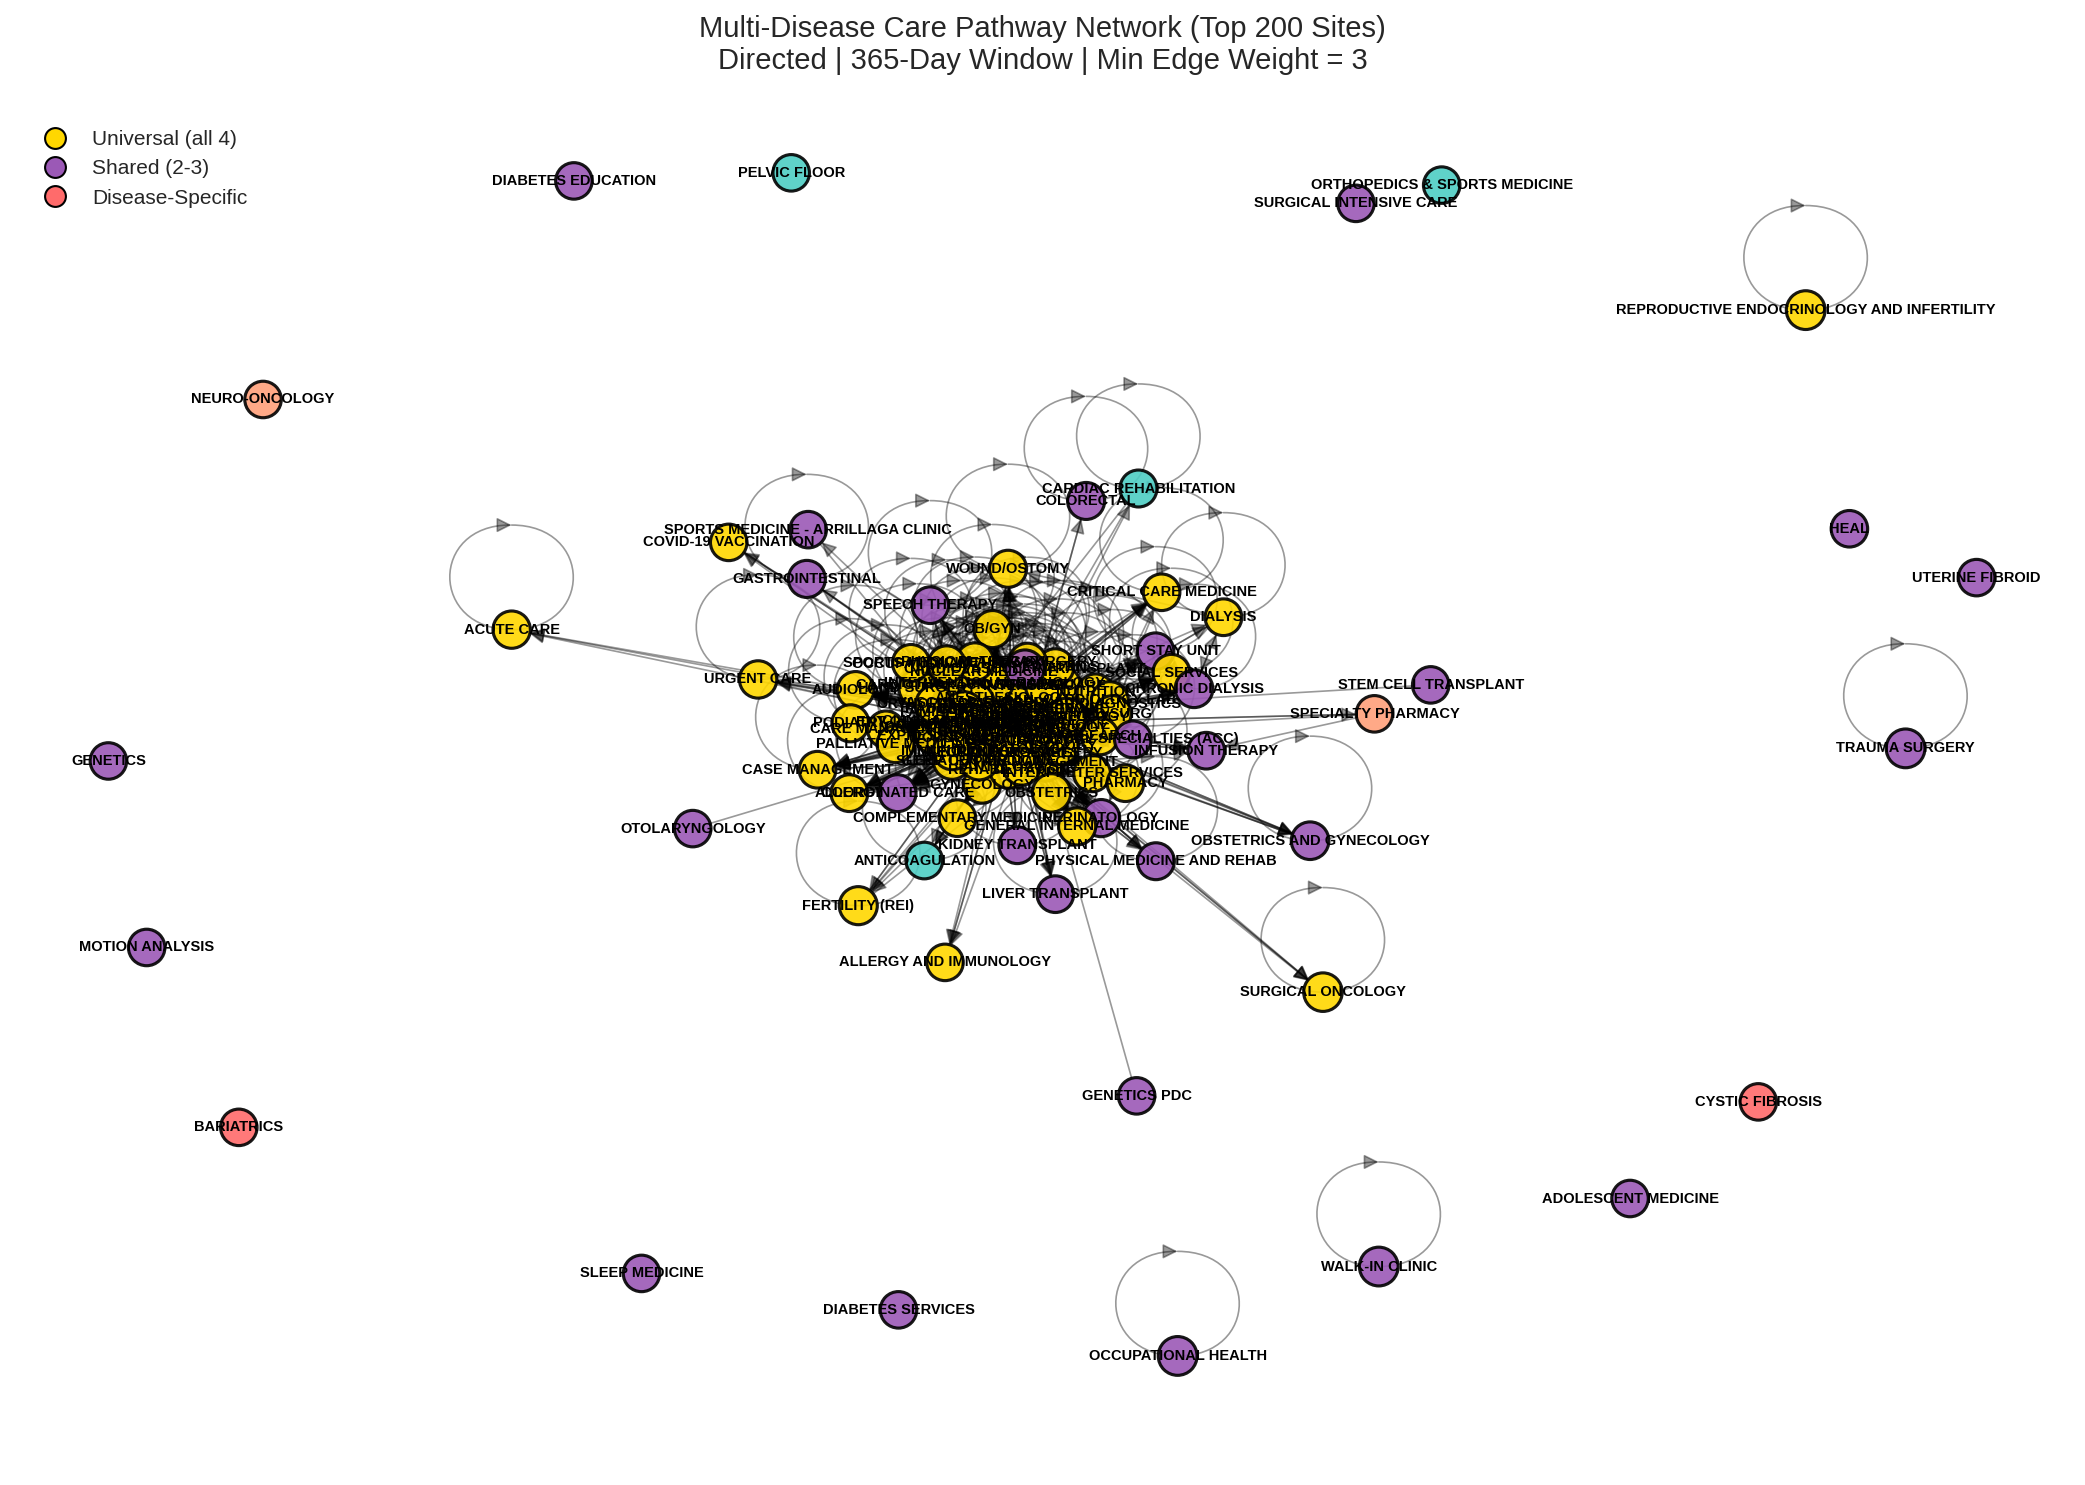

In [10]:
# Static Visualization
fig, ax = plt.subplots(figsize=(14,10))
pos = nx.spring_layout(G_top, seed=42, k=0.5)

node_categories = {}

for node in combined_G.nodes():
    # Which diseases use this node
    diseases_using = [d for d, g in disease_networks.items() if node in g.nodes()]
    num_diseases = len(diseases_using)

    # Categorize based on number of diseases
    if num_diseases == 4:
        color = '#FFD700'  # Gold
        category = 'Universal'
    elif num_diseases >= 2:
        color = '#9B59B6'  # Purple
        category = 'Shared'
    else:
        # Disease-specific: use disease color
        color = disease_colors[diseases_using[0]]
        category = diseases_using[0]

    node_categories[node] = {
        'color': color,
        'category': category,
        'diseases': diseases_using,
        'disease_count': num_diseases
    }

node_colors = [node_categories[n]['color'] for n in G_top.nodes()]
node_sizes = [300 + metrics.loc[n, 'pagerank'] * 5000 for n in G_top.nodes()]
nx.draw_networkx_nodes(G_top, pos, node_color=node_colors, node_size=node_sizes,
                       alpha=0.9, linewidths=1.5, edgecolors='black', ax=ax)

nx.draw_networkx_edges(G_top, pos, arrows=True, arrowstyle='-|>',
                       arrowsize=15, alpha=0.4, width=0.8, ax=ax)

nx.draw_networkx_labels(G_top, pos, font_size=7, font_weight='bold', ax=ax)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Universal (all 4)',
               markerfacecolor='#FFD700', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Shared (2-3)',
               markerfacecolor='#9B59B6', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='Disease-Specific',
               markerfacecolor='#FF6B6B', markersize=10, markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

ax.set_title(f"Multi-Disease Care Pathway Network (Top {TOP_N_SITES} Sites)\n"
             f"Directed | 365-Day Window | Min Edge Weight = {MIN_EDGE_WEIGHT}",
             fontsize=14, pad=20)
ax.axis('off')
plt.tight_layout()
plt.savefig('network_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Complete Interactive Contextual Network for Individual Diseases

import json
from datetime import datetime

def create_contextual_network(G, disease_name, color, output_file):
    """
    Complete network with clinical context and proper selection tracking
    """

    pos = nx.spring_layout(G, seed=42, k=2.0, iterations=50)
    scale = 1200
    for node in pos:
        pos[node] = (pos[node][0] * scale, pos[node][1] * scale)

    def get_transition_reason(from_site, to_site, count):
        """Generate clinical reasoning for transitions"""
        from_lower = from_site.lower()
        to_lower = to_site.lower()

        if 'primary' in from_lower and any(x in to_lower for x in ['specialist', 'cardiology', 'oncology', 'neurology']):
            return "specialist referrals for advanced diagnosis or treatment"
        elif 'emergency' in from_lower or 'urgent' in from_lower:
            return "urgent care admissions requiring immediate attention"
        elif any(x in to_lower for x in ['surgery', 'surgical', 'operating']):
            return "patients requiring surgical intervention"
        elif any(x in to_lower for x in ['rehab', 'physical therapy', 'recovery']):
            return "post-treatment recovery and rehabilitation"
        elif any(x in to_lower for x in ['radiology', 'imaging', 'radiation']):
            return "diagnostic imaging or radiation therapy"
        elif any(x in to_lower for x in ['lab', 'pathology', 'diagnostic']):
            return "diagnostic testing and lab work"
        elif 'pharmacy' in to_lower or 'medication' in to_lower:
            return "medication management and prescriptions"
        elif count > 100:
            return "a standard, high-volume care pathway in the treatment protocol"
        else:
            return "routine follow-up care or specialized consultations"

    def get_node_role_and_explanation(node, G):
        in_deg, out_deg = G.in_degree(node), G.out_degree(node)

        if in_deg == 0 and out_deg > 0:
            return "Entry Point", "Patients typically start their care journey here (initial diagnosis or referral)"
        elif out_deg == 0 and in_deg > 0:
            return "Exit Point", "Patients typically end treatment or are discharged from this facility"
        elif in_deg > 5 and out_deg > 5:
            return "Major Hub", "Central coordination point - patients frequently move to/from this site for specialized care or follow-ups"
        elif in_deg > out_deg * 2:
            return "Referral Destination", "Receives many referrals - likely a specialist center or advanced treatment facility"
        elif out_deg > in_deg * 2:
            return "Referral Source", "Sends patients elsewhere - often primary care or screening center"
        else:
            return "Transition Point", "Intermediate care site - part of multi-step treatment pathways"

    adjacency = {}
    edge_explanations = {}

    for idx, (u, v, data) in enumerate(G.edges(data=True)):
        weight = data.get('weight', 1)

        if weight > 100:
            strength = "very common"
        elif weight > 50:
            strength = "common"
        elif weight > 20:
            strength = "regular"
        else:
            strength = "occasional"

        explanation = f"{strength.capitalize()} pathway: {weight} patients moved from {u} to {v}. This likely represents {get_transition_reason(u, v, weight)}"

        if u not in adjacency:
            adjacency[u] = {'nodes': set(), 'edges': set()}
        if v not in adjacency:
            adjacency[v] = {'nodes': set(), 'edges': set()}

        adjacency[u]['nodes'].add(v)
        adjacency[u]['edges'].add(idx)
        adjacency[v]['nodes'].add(u)
        adjacency[v]['edges'].add(idx)

        edge_explanations[idx] = {'from': u, 'to': v, 'weight': weight, 'explanation': explanation}

    nodes_data = []
    for node in G.nodes():
        in_deg = G.in_degree(node, weight='weight')
        out_deg = G.out_degree(node, weight='weight')
        total = in_deg + out_deg
        role, explanation = get_node_role_and_explanation(node, G)

        incoming_from = [f"{n} ({G[n][node]['weight']} pts)" for n in G.predecessors(node)][:5]
        outgoing_to = [f"{n} ({G[node][n]['weight']} pts)" for n in G.successors(node)][:5]

        nodes_data.append({
            'id': node,
            'name': node,
            'x': float(pos[node][0]),
            'y': float(pos[node][1]),
            'color': color,
            'in_degree': int(in_deg),
            'out_degree': int(out_deg),
            'total_traffic': int(total),
            'role': role,
            'explanation': explanation,
            'is_entry': G.in_degree(node) == 0 and G.out_degree(node) > 0,
            'is_exit': G.out_degree(node) == 0 and G.in_degree(node) > 0,
            'connected_nodes': list(adjacency.get(node, {}).get('nodes', [])),
            'connected_edges': list(adjacency.get(node, {}).get('edges', [])),
            'incoming_from': incoming_from,
            'outgoing_to': outgoing_to
        })

    edges_data = [{'id': idx, **data} for idx, data in edge_explanations.items()]

    html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>{disease_name} Clinical Pathway Network</title>
    <script src="https://unpkg.com/vis-network@9.1.2/standalone/umd/vis-network.min.js"></script>
    <style>
        *{{margin:0;padding:0;box-sizing:border-box;}}
        body{{font-family:'Segoe UI',Arial,sans-serif;background:#f8f9fa;padding:20px;}}
        #container{{max-width:1600px;margin:0 auto;}}
        #info-panel{{background:white;border-radius:8px;padding:20px;margin-bottom:20px;box-shadow:0 2px 8px rgba(0,0,0,0.1);}}
        h1{{color:#333;margin-bottom:10px;font-size:20px;}}
        .stats{{display:flex;gap:30px;margin:15px 0;}}
        .stat-item{{font-size:14px;}}
        .stat-label{{color:#666;margin-right:5px;}}
        .stat-value{{font-weight:bold;color:{color};}}
        #network{{width:100%;height:750px;background:white;border-radius:8px;box-shadow:0 2px 8px rgba(0,0,0,0.1);}}
        #detail-box{{position:fixed;top:120px;right:30px;width:380px;background:white;border-radius:8px;padding:20px;box-shadow:0 4px 16px rgba(0,0,0,0.15);display:none;z-index:1000;max-height:80vh;overflow-y:auto;}}
        #detail-box.visible{{display:block;}}
        #detail-box h3{{margin:0 0 12px 0;color:{color};font-size:17px;}}
        .detail-section{{margin:12px 0;padding:12px;background:#f8f9fa;border-radius:6px;}}
        .detail-section h4{{margin:0 0 8px 0;font-size:13px;color:#555;text-transform:uppercase;letter-spacing:0.5px;}}
        .detail-item{{margin:6px 0;font-size:13px;line-height:1.5;}}
        .detail-label{{font-weight:600;color:#555;}}
        .explanation{{color:#666;font-style:italic;margin-top:6px;font-size:12px;line-height:1.4;}}
        .pathway-list{{margin:6px 0;padding-left:8px;}}
        .pathway-list li{{margin:4px 0;font-size:12px;color:#666;}}
        .blink-badge{{display:inline-block;padding:3px 8px;border-radius:12px;background:#FF6B6B;color:white;font-size:10px;font-weight:bold;margin-left:8px;animation:blink 1.5s infinite;}}
        @keyframes blink{{0%,100%{{opacity:1;}}50%{{opacity:0.3;}}}}
        #reset-btn{{margin-top:12px;padding:10px 18px;background:{color};color:white;border:none;border-radius:6px;cursor:pointer;font-size:13px;font-weight:600;}}
        #reset-btn:hover{{opacity:0.9;}}
        #instructions{{margin-top:12px;padding:12px;background:#f0f7ff;border-left:4px solid {color};border-radius:4px;}}
        #instructions p{{margin:4px 0;font-size:12px;color:#555;}}
    </style>
</head>
<body>
    <div id="container">
        <div id="info-panel">
            <h1>{disease_name} Clinical Care Pathway Network</h1>
            <div class="stats">
                <div class="stat-item"><span class="stat-label">Care Sites:</span><span class="stat-value">{len(nodes_data)}</span></div>
                <div class="stat-item"><span class="stat-label">Pathways:</span><span class="stat-value">{len(edges_data)}</span></div>
                <div class="stat-item"><span class="stat-label">Patient Flows:</span><span class="stat-value">{sum(e['weight'] for e in edges_data):,}</span></div>
            </div>
            <div id="instructions">
                <p><strong>👆 Hover</strong> over nodes | <strong>🖱️ Click</strong> for clinical pathway analysis</p>
            </div>
        </div>
        <div id="network"></div>
        <div id="detail-box">
            <h3>Pathway Analysis</h3>
            <div class="detail-section">
                <h4>Site Information</h4>
                <div class="detail-item"><span class="detail-label">Name:</span> <span id="detail-name"></span></div>
                <div class="detail-item"><span class="detail-label">Role:</span> <span id="detail-role"></span></div>
                <div class="explanation" id="detail-explanation"></div>
            </div>
            <div class="detail-section">
                <h4>Patient Flow</h4>
                <div class="detail-item"><span class="detail-label">Incoming:</span> <span id="detail-in"></span> patients</div>
                <div class="detail-item"><span class="detail-label">Outgoing:</span> <span id="detail-out"></span> patients</div>
                <div class="detail-item"><span class="detail-label">Total:</span> <span id="detail-total"></span></div>
            </div>
            <div class="detail-section">
                <h4>Top Incoming Pathways</h4>
                <ul class="pathway-list" id="incoming-list"></ul>
            </div>
            <div class="detail-section">
                <h4>Top Outgoing Pathways</h4>
                <ul class="pathway-list" id="outgoing-list"></ul>
            </div>
        </div>
    </div>
    <script>
        const nodesData = {json.dumps(nodes_data)};
        const edgesData = {json.dumps(edges_data)};
        const container = document.getElementById('network');
        const detailBox = document.getElementById('detail-box');
        const nodeMap = new Map(nodesData.map(n => [n.id, n]));
        const allNodeIds = nodesData.map(n => n.id);
        const allEdgeIds = edgesData.map(e => e.id);

        const nodes = new vis.DataSet(nodesData.map(n => ({{
            id: n.id, x: n.x, y: n.y, size: 25,
            fixed: {{x: true, y: true}},
            color: {{background: n.color, border: '#2c3e50', highlight: {{background: '#FFD700', border: '#FF6B00'}}}},
            borderWidth: 2,
            title: n.name + '\\nTraffic: ' + n.total_traffic.toLocaleString()
        }})));

        const edges = new vis.DataSet(edgesData.map(e => ({{
            id: e.id, from: e.from, to: e.to,
            arrows: {{to: {{enabled: true, scaleFactor: 0.8}}}},
            color: {{color: 'rgba(100,100,100,0.25)', highlight: '#FFD700'}},
            smooth: {{type: 'continuous', roundness: 0.2}},
            width: 1
        }})));

        const network = new vis.Network(container, {{nodes, edges}}, {{
            physics: {{enabled: false}},
            interaction: {{hover: true, tooltipDelay: 100}}
        }});

        let blinkInterval = null;
        let previouslySelected = null;

        network.on('click', params => {{
            if (params.nodes.length > 0) highlightNode(params.nodes[0]);
            else resetNetwork();
        }});

        function highlightNode(nodeId) {{
            const nodeData = nodeMap.get(nodeId);
            if (!nodeData) return;

            // Reset previously selected node
            if (previouslySelected && previouslySelected !== nodeId) {{
                const prevData = nodeMap.get(previouslySelected);
                if (prevData) {{
                    nodes.update({{
                        id: previouslySelected,
                        color: {{background: prevData.color, border: '#2c3e50'}},
                        borderWidth: 2
                    }});
                }}
            }}

            let roleText = nodeData.role;
            if (nodeData.is_entry) roleText += '<span class="blink-badge">START</span>';
            else if (nodeData.is_exit) roleText += '<span class="blink-badge">END</span>';

            document.getElementById('detail-name').textContent = nodeData.name;
            document.getElementById('detail-role').innerHTML = roleText;
            document.getElementById('detail-explanation').textContent = nodeData.explanation;
            document.getElementById('detail-in').textContent = nodeData.in_degree.toLocaleString();
            document.getElementById('detail-out').textContent = nodeData.out_degree.toLocaleString();
            document.getElementById('detail-total').textContent = nodeData.total_traffic.toLocaleString();

            const incomingList = document.getElementById('incoming-list');
            incomingList.innerHTML = nodeData.incoming_from.length > 0
                ? nodeData.incoming_from.map(p => `<li>← ${{p}}</li>`).join('')
                : '<li style="color:#999;">No incoming</li>';

            const outgoingList = document.getElementById('outgoing-list');
            outgoingList.innerHTML = nodeData.outgoing_to.length > 0
                ? nodeData.outgoing_to.map(p => `<li>→ ${{p}}</li>`).join('')
                : '<li style="color:#999;">No outgoing</li>';

            detailBox.classList.add('visible');

            const connectedNodes = new Set([nodeId, ...nodeData.connected_nodes]);
            const connectedEdges = new Set(nodeData.connected_edges);

            nodes.update(allNodeIds.map(id => {{
                if (id === nodeId) {{
                    return {{id, borderWidth: 5, color: {{background: nodeData.color, border: '#2c3e50'}}}};
                }} else if (connectedNodes.has(id)) {{
                    const n = nodeMap.get(id);
                    return {{id, opacity: 1, color: {{background: n.color, border: '#2c3e50'}}}};
                }} else {{
                    return {{id, color: {{background: '#e8e8e8', border: '#bbb'}}, opacity: 0.2}};
                }}
            }}));

            edges.update(allEdgeIds.map(id =>
                connectedEdges.has(id)
                    ? {{id, color: {{color: '#FFD700'}}, width: 4}}
                    : {{id, opacity: 0.08}}
            ));

            previouslySelected = nodeId;

            if (blinkInterval) clearInterval(blinkInterval);
            const blinkNodes = nodeData.connected_nodes.filter(id => {{
                const n = nodeMap.get(id);
                return n && (n.is_entry || n.is_exit);
            }});

            if (blinkNodes.length > 0) {{
                let blink = true;
                blinkInterval = setInterval(() => {{
                    nodes.update(blinkNodes.map(id => ({{id, borderWidth: blink ? 6 : 2}})));
                    blink = !blink;
                }}, 600);
            }}
        }}

        function resetNetwork() {{
            detailBox.classList.remove('visible');
            previouslySelected = null;

            if (blinkInterval) {{
                clearInterval(blinkInterval);
                blinkInterval = null;
            }}

            nodes.update(allNodeIds.map(id => ({{
                id,
                color: {{background: nodeMap.get(id).color, border: '#2c3e50'}},
                borderWidth: 2,
                opacity: 1
            }})));

            edges.update(allEdgeIds.map(id => ({{
                id,
                color: {{color: 'rgba(100,100,100,0.25)'}},
                width: 1,
                opacity: 1
            }})));
        }}
    </script>
</body>
</html>
"""

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"{output_file}")

print("GENERATING INTERACTIVE GRAPHS FOR INDIVIDUAL DISEASES")
print("="*70)
for disease_name, G in disease_networks.items():
    color = disease_colors[disease_name]
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"pathway_{disease_name.replace(' ', '_').lower()}_{timestamp}.html"
    create_contextual_network(G, disease_name, color, filename)

print("\n✓ All networks generated with proper selection tracking!")


GENERATING INTERACTIVE GRAPHS FOR INDIVIDUAL DISEASES
pathway_diabetes_20251026_055033.html
pathway_heart_disease_20251026_055033.html
pathway_cancer_20251026_055033.html
pathway_chronic_kidney_disease_20251026_055033.html

✓ All networks generated with proper selection tracking!


In [12]:
# Combined Network with all the 4 diseases and their care pathways

import json
from datetime import datetime

def create_enhanced_combined_network(disease_networks, disease_colors, output_file):
    """
    Enhanced combined network with comprehensive site analysis
    """

    # Build combined graph
    combined_G = nx.DiGraph(name='Combined')
    node_diseases = {}

    for disease_name, G in disease_networks.items():
        for u, v, data in G.edges(data=True):
            weight = data.get('weight', 1)

            if u not in node_diseases:
                node_diseases[u] = set()
            if v not in node_diseases:
                node_diseases[v] = set()
            node_diseases[u].add(disease_name)
            node_diseases[v].add(disease_name)

            if combined_G.has_edge(u, v):
                combined_G[u][v]['weight'] += weight
                combined_G[u][v]['diseases'].add(disease_name)
            else:
                combined_G.add_edge(u, v, weight=weight, diseases={disease_name})

    # Compute PageRank
    pagerank = nx.pagerank(combined_G, weight='weight')
    max_pr = max(pagerank.values())

    # Layout
    pos = nx.spring_layout(combined_G, seed=42, k=2.5, iterations=50)
    scale = 1400
    for node in pos:
        pos[node] = (pos[node][0] * scale, pos[node][1] * scale)

    def get_node_color_and_category(node, diseases_set):
        num_diseases = len(diseases_set)
        if num_diseases == 4:
            return '#FFD700', 'Universal', 'Critical shared infrastructure used across all disease pathways'
        elif num_diseases == 3:
            return '#9B59B6', 'Shared (3 diseases)', f'Multi-disease coordination point for: {", ".join(sorted(diseases_set))}'
        elif num_diseases == 2:
            return '#8E44AD', 'Shared (2 diseases)', f'Shared care facility for: {", ".join(sorted(diseases_set))}'
        else:
            disease = list(diseases_set)[0]
            return disease_colors[disease], f'{disease}-Specific', f'Specialized care facility dedicated to {disease} patients'

    def get_node_role(node, G):
        """Determine site's role in care ecosystem"""
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        in_weight = G.in_degree(node, weight='weight')
        out_weight = G.out_degree(node, weight='weight')

        if in_deg == 0 and out_deg > 0:
            return "Initial Entry Point", "Patients typically begin their care journey here"
        elif out_deg == 0 and in_deg > 0:
            return "Terminal Care Point", "Final stage of treatment or discharge location"
        elif in_deg > 10 and out_deg > 10:
            return "Major Care Hub", "Central coordination facility with high patient turnover"
        elif in_weight > out_weight * 2:
            return "Referral Destination", "Receives patients from multiple sources for specialized care"
        elif out_weight > in_weight * 2:
            return "Referral Source", "Primary care or screening center that refers patients to specialists"
        elif in_deg > 5 or out_deg > 5:
            return "Active Care Site", "Regular patient flow with balanced referrals"
        else:
            return "Specialty Care Point", "Focused treatment facility with selective patient intake"

    # Build adjacency and gather connection details
    adjacency = {}
    edge_data = {}

    for idx, (u, v, data) in enumerate(combined_G.edges(data=True)):
        weight = data['weight']
        diseases_list = list(data['diseases'])

        if u not in adjacency:
            adjacency[u] = {'nodes': set(), 'edges': set()}
        if v not in adjacency:
            adjacency[v] = {'nodes': set(), 'edges': set()}

        adjacency[u]['nodes'].add(v)
        adjacency[u]['edges'].add(idx)
        adjacency[v]['nodes'].add(u)
        adjacency[v]['edges'].add(idx)

        edge_data[idx] = {'from': u, 'to': v, 'weight': weight, 'diseases': diseases_list}

    # Prepare nodes with full context
    nodes_data = []
    for node in combined_G.nodes():
        diseases_set = node_diseases[node]
        color, category, explanation = get_node_color_and_category(node, diseases_set)
        role, role_desc = get_node_role(node, combined_G)

        in_deg = combined_G.in_degree(node, weight='weight')
        out_deg = combined_G.out_degree(node, weight='weight')
        total = in_deg + out_deg
        pr = pagerank[node]
        size = 15 + (pr / max_pr) * 50

        # Get top connections
        top_incoming = sorted(
            [(pred, combined_G[pred][node]['weight']) for pred in combined_G.predecessors(node)],
            key=lambda x: x[1], reverse=True
        )[:5]

        top_outgoing = sorted(
            [(succ, combined_G[node][succ]['weight']) for succ in combined_G.successors(node)],
            key=lambda x: x[1], reverse=True
        )[:5]

        nodes_data.append({
            'id': node,
            'name': node,
            'x': float(pos[node][0]),
            'y': float(pos[node][1]),
            'size': float(size),
            'color': color,
            'category': category,
            'explanation': explanation,
            'role': role,
            'role_description': role_desc,
            'diseases': list(diseases_set),
            'num_diseases': len(diseases_set),
            'in_degree': int(in_deg),
            'out_degree': int(out_deg),
            'total_traffic': int(total),
            'pagerank': round(pr, 4),
            'connected_nodes': list(adjacency.get(node, {}).get('nodes', [])),
            'connected_edges': list(adjacency.get(node, {}).get('edges', [])),
            'top_incoming': [(n, int(w)) for n, w in top_incoming],
            'top_outgoing': [(n, int(w)) for n, w in top_outgoing]
        })

    edges_list = [{'id': idx, **data} for idx, data in edge_data.items()]

    universal = sum(1 for n in nodes_data if n['num_diseases'] == 4)
    shared = sum(1 for n in nodes_data if 2 <= n['num_diseases'] <= 3)
    specific = sum(1 for n in nodes_data if n['num_diseases'] == 1)

    html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <!-- Prevent caching -->
    <meta http-equiv="Cache-Control" content="no-cache, no-store, must-revalidate">
    <meta http-equiv="Pragma" content="no-cache">
    <meta http-equiv="Expires" content="0">
    <title>Combined Multi-Disease Network</title>
    <script src="https://unpkg.com/vis-network@9.1.2/standalone/umd/vis-network.min.js"></script>
    <style>
        *{{margin:0;padding:0;box-sizing:border-box;}}
        body{{font-family:'Segoe UI',Arial,sans-serif;background:#f8f9fa;padding:20px;}}
        #container{{max-width:1600px;margin:0 auto;}}
        #info-panel{{background:white;border-radius:8px;padding:20px;margin-bottom:20px;box-shadow:0 2px 8px rgba(0,0,0,0.1);}}
        h1{{color:#333;margin-bottom:10px;font-size:22px;}}
        .stats{{display:flex;gap:30px;margin:15px 0;flex-wrap:wrap;}}
        .stat-item{{font-size:14px;}}
        .stat-label{{color:#666;margin-right:5px;}}
        .stat-value{{font-weight:bold;color:#2c3e50;}}
        #network{{width:100%;height:800px;background:white;border-radius:8px;box-shadow:0 2px 8px rgba(0,0,0,0.1);}}
        #detail-box{{position:fixed;top:100px;right:30px;width:420px;background:white;border-radius:8px;padding:20px;box-shadow:0 4px 16px rgba(0,0,0,0.15);display:none;z-index:1000;max-height:85vh;overflow-y:auto;}}
        #detail-box.visible{{display:block;}}
        #detail-box h3{{margin:0 0 12px 0;color:#2c3e50;font-size:18px;border-bottom:2px solid #e0e0e0;padding-bottom:8px;}}
        .detail-section{{margin:14px 0;padding:14px;background:#f8f9fa;border-radius:6px;border-left:4px solid #2c3e50;}}
        .detail-section h4{{margin:0 0 10px 0;font-size:13px;color:#555;text-transform:uppercase;letter-spacing:0.5px;}}
        .detail-item{{margin:8px 0;font-size:13px;line-height:1.6;}}
        .detail-label{{font-weight:600;color:#555;display:inline-block;min-width:100px;}}
        .explanation{{color:#666;font-style:italic;margin-top:8px;font-size:12px;line-height:1.5;padding:8px;background:#fff;border-radius:4px;}}
        .disease-badge{{display:inline-block;padding:4px 10px;margin:3px;border-radius:14px;font-size:11px;font-weight:600;color:white;}}
        .connection-list{{margin:8px 0;padding:0;}}
        .connection-list li{{list-style:none;padding:6px 8px;margin:4px 0;background:white;border-radius:4px;font-size:12px;border-left:3px solid #2c3e50;}}
        .connection-arrow{{color:#999;margin:0 6px;}}
        #reset-btn{{margin-top:12px;padding:10px 18px;background:#2c3e50;color:white;border:none;border-radius:6px;cursor:pointer;font-size:13px;font-weight:600;}}
        #reset-btn:hover{{opacity:0.9;}}
        #legend{{margin-top:15px;padding:15px;background:#fff;border:2px solid #e0e0e0;border-radius:8px;}}
        #legend h3{{margin:0 0 10px 0;font-size:14px;color:#555;}}
        .legend-item{{display:flex;align-items:center;margin:8px 0;font-size:13px;}}
        .legend-color{{width:20px;height:20px;border-radius:50%;margin-right:10px;border:2px solid #2c3e50;}}
        #instructions{{margin-top:12px;padding:12px;background:#f0f7ff;border-left:4px solid #2c3e50;border-radius:4px;}}
        #instructions p{{margin:4px 0;font-size:12px;color:#555;}}
    </style>
</head>
<body>
    <div id="container">
        <div id="info-panel">
            <h1>Combined Multi-Disease Care Pathway Network</h1>
            <div class="stats">
                <div class="stat-item"><span class="stat-label">Total Sites:</span><span class="stat-value">{len(nodes_data)}</span></div>
                <div class="stat-item"><span class="stat-label">Universal:</span><span class="stat-value" style="color:#FFD700;">{universal}</span></div>
                <div class="stat-item"><span class="stat-label">Shared:</span><span class="stat-value" style="color:#9B59B6;">{shared}</span></div>
                <div class="stat-item"><span class="stat-label">Disease-Specific:</span><span class="stat-value">{specific}</span></div>
                <div class="stat-item"><span class="stat-label">Total Flows:</span><span class="stat-value">{sum(e['weight'] for e in edges_list):,}</span></div>
            </div>
            <div id="legend">
                <h3>Node Categories</h3>
                <div class="legend-item"><div class="legend-color" style="background:#FFD700;"></div><strong>Universal</strong> - Critical infrastructure for all 4 diseases</div>
                <div class="legend-item"><div class="legend-color" style="background:#9B59B6;"></div><strong>Shared</strong> - Multi-disease coordination (2-3 diseases)</div>
                <div class="legend-item"><div class="legend-color" style="background:#FF6B6B;"></div><strong>Disease-Specific</strong> - Specialized for one disease only</div>
            </div>
            <div id="instructions">
                <p><strong>👆 Hover</strong> for quick info | <strong>🖱️ Click</strong> for comprehensive analysis with pathways</p>
            </div>
        </div>
        <div id="network"></div>
        <div id="detail-box">
            <h3>Comprehensive Site Analysis</h3>

            <div class="detail-section" style="border-left-color:#2c3e50;">
                <h4>🏥 Site Identity</h4>
                <div class="detail-item"><span class="detail-label">Name:</span><span id="detail-name"></span></div>
                <div class="detail-item"><span class="detail-label">Category:</span><span id="detail-category"></span></div>
                <div class="explanation" id="detail-explanation"></div>
            </div>

            <div class="detail-section" style="border-left-color:#9B59B6;">
                <h4>🎯 Care Role</h4>
                <div class="detail-item"><span class="detail-label">Role:</span><span id="detail-role"></span></div>
                <div class="explanation" id="detail-role-desc"></div>
            </div>

            <div class="detail-section" style="border-left-color:#3498db;">
                <h4>🏥 Disease Coverage</h4>
                <div id="disease-badges"></div>
            </div>

            <div class="detail-section" style="border-left-color:#27ae60;">
                <h4>📊 Patient Traffic</h4>
                <div class="detail-item"><span class="detail-label">Incoming:</span><span id="detail-in"></span> patients</div>
                <div class="detail-item"><span class="detail-label">Outgoing:</span><span id="detail-out"></span> patients</div>
                <div class="detail-item"><span class="detail-label">Total Traffic:</span><span id="detail-total"></span></div>
                <div class="detail-item"><span class="detail-label">PageRank:</span><span id="detail-pr"></span></div>
            </div>

            <div class="detail-section" style="border-left-color:#e74c3c;">
                <h4>⬅️ Top Incoming Pathways</h4>
                <ul class="connection-list" id="incoming-list"></ul>
            </div>

            <div class="detail-section" style="border-left-color:#f39c12;">
                <h4>➡️ Top Outgoing Pathways</h4>
                <ul class="connection-list" id="outgoing-list"></ul>
            </div>
        </div>
    </div>
    <script>
        const nodesData = {json.dumps(nodes_data)};
        const edgesData = {json.dumps(edges_list)};
        const diseaseColors = {json.dumps(disease_colors)};
        const container = document.getElementById('network');
        const detailBox = document.getElementById('detail-box');
        const nodeMap = new Map(nodesData.map(n => [n.id, n]));
        const allNodeIds = nodesData.map(n => n.id);
        const allEdgeIds = edgesData.map(e => e.id);

        const nodes = new vis.DataSet(nodesData.map(n => ({{
            id: n.id, x: n.x, y: n.y, size: n.size,
            fixed: {{x: true, y: true}},
            color: {{background: n.color, border: '#2c3e50', highlight: {{background: '#FFD700', border: '#FF6B00'}}}},
            borderWidth: 2.5,
            title: n.name + '\\n' + n.category + '\\nRole: ' + n.role
        }})));

        const edges = new vis.DataSet(edgesData.map(e => ({{
            id: e.id, from: e.from, to: e.to,
            arrows: {{to: {{enabled: true, scaleFactor: 0.8}}}},
            color: {{color: 'rgba(100,100,100,0.2)', highlight: '#FFD700'}},
            smooth: {{type: 'continuous', roundness: 0.2}},
            width: 1
        }})));

        const network = new vis.Network(container, {{nodes, edges}}, {{
            physics: {{enabled: false}},
            interaction: {{hover: true, tooltipDelay: 100}}
        }});

        let previouslySelected = null;

        network.on('click', params => {{
            if (params.nodes.length > 0) highlightNode(params.nodes[0]);
            else resetNetwork();
        }});

        function highlightNode(nodeId) {{
            const nodeData = nodeMap.get(nodeId);
            if (!nodeData) return;

            if (previouslySelected && previouslySelected !== nodeId) {{
                const prevData = nodeMap.get(previouslySelected);
                if (prevData) nodes.update({{id: previouslySelected, color: {{background: prevData.color, border: '#2c3e50'}}, borderWidth: 2.5}});
            }}

            document.getElementById('detail-name').textContent = nodeData.name;
            document.getElementById('detail-category').textContent = nodeData.category;
            document.getElementById('detail-explanation').textContent = nodeData.explanation;
            document.getElementById('detail-role').textContent = nodeData.role;
            document.getElementById('detail-role-desc').textContent = nodeData.role_description;
            document.getElementById('detail-in').textContent = nodeData.in_degree.toLocaleString();
            document.getElementById('detail-out').textContent = nodeData.out_degree.toLocaleString();
            document.getElementById('detail-total').textContent = nodeData.total_traffic.toLocaleString();
            document.getElementById('detail-pr').textContent = nodeData.pagerank;

            const badgesHtml = nodeData.diseases.map(d => `<span class="disease-badge" style="background:${{diseaseColors[d]}};">${{d}}</span>`).join('');
            document.getElementById('disease-badges').innerHTML = badgesHtml;

            const incomingHtml = nodeData.top_incoming.length > 0
                ? nodeData.top_incoming.map(([name, count]) => `<li><span class="connection-arrow">←</span>${{name}} <strong>(${{count}} patients)</strong></li>`).join('')
                : '<li style="color:#999;">No incoming connections</li>';
            document.getElementById('incoming-list').innerHTML = incomingHtml;

            const outgoingHtml = nodeData.top_outgoing.length > 0
                ? nodeData.top_outgoing.map(([name, count]) => `<li><span class="connection-arrow">→</span>${{name}} <strong>(${{count}} patients)</strong></li>`).join('')
                : '<li style="color:#999;">No outgoing connections</li>';
            document.getElementById('outgoing-list').innerHTML = outgoingHtml;

            detailBox.classList.add('visible');

            const connectedNodes = new Set([nodeId, ...nodeData.connected_nodes]);
            const connectedEdges = new Set(nodeData.connected_edges);

            nodes.update(allNodeIds.map(id => {{
                if (id === nodeId) return {{id, borderWidth: 6, color: {{background: nodeData.color, border: '#2c3e50'}}}};
                else if (connectedNodes.has(id)) {{
                    const n = nodeMap.get(id);
                    return {{id, opacity: 1, color: {{background: n.color, border: '#2c3e50'}}}};
                }}
                else return {{id, color: {{background: '#e8e8e8', border: '#bbb'}}, opacity: 0.2}};
            }}));

            edges.update(allEdgeIds.map(id => connectedEdges.has(id) ? {{id, color: {{color: '#FFD700'}}, width: 5}} : {{id, opacity: 0.05}}));
            previouslySelected = nodeId;
        }}

        function resetNetwork() {{
            detailBox.classList.remove('visible');
            previouslySelected = null;
            nodes.update(allNodeIds.map(id => ({{id, color: {{background: nodeMap.get(id).color, border: '#2c3e50'}}, borderWidth: 2.5, opacity: 1}})));
            edges.update(allEdgeIds.map(id => ({{id, color: {{color: 'rgba(100,100,100,0.2)'}}, width: 1, opacity: 1}})));
        }}
    </script>
</body>
</html>
"""

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"✓ {output_file}")
    print(f"   Universal: {universal} | Shared: {shared} | Specific: {specific}")
print("GENERATING COMPLETED GRAPH NETWORK OF THE SELECTED DISEASES")
print("="*70)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"combined_multidisease_network_{timestamp}.html"
create_enhanced_combined_network(disease_networks, disease_colors, filename)


print("Enhanced combined network created!")


GENERATING COMPLETED GRAPH NETWORK OF THE SELECTED DISEASES
✓ combined_multidisease_network_20251026_055033.html
   Universal: 66 | Shared: 30 | Specific: 10
Enhanced combined network created!


In [13]:
# Comprehensive Network Metrics Analysis

import pandas as pd
import numpy as np
from collections import defaultdict

def analyze_network_metrics(networks_dict):
    """
    Compute comprehensive metrics for all networks
    """

    metrics_results = {}

    for network_name, G in networks_dict.items():
        print(f"\n{'='*60}")
        print(f"Analyzing: {network_name}")
        print(f"{'='*60}")

        # Basic metrics
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)

        # Degree statistics
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        weighted_in = dict(G.in_degree(weight='weight'))
        weighted_out = dict(G.out_degree(weight='weight'))

        avg_in_degree = np.mean(list(in_degrees.values()))
        avg_out_degree = np.mean(list(out_degrees.values()))
        avg_weighted_in = np.mean(list(weighted_in.values()))
        avg_weighted_out = np.mean(list(weighted_out.values()))

        # Centrality measures
        print("Computing centrality metrics...")
        betweenness = nx.betweenness_centrality(G, weight='weight')
        closeness = nx.closeness_centrality(G)
        pagerank = nx.pagerank(G, weight='weight')

        # Find top nodes by different metrics
        top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
        top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
        top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

        # Community detection
        print("Detecting communities...")
        G_undirected = G.to_undirected()
        communities = nx.community.louvain_communities(G_undirected, weight='weight', seed=42)
        modularity = nx.community.modularity(G_undirected, communities, weight='weight')

        # Clustering coefficient
        clustering_coef = nx.average_clustering(G_undirected, weight='weight')

        # Strongly connected components (for directed graph)
        scc = list(nx.strongly_connected_components(G))
        num_scc = len(scc)
        largest_scc_size = len(max(scc, key=len)) if scc else 0

        # Weakly connected components
        wcc = list(nx.weakly_connected_components(G))
        num_wcc = len(wcc)

        # Store results
        metrics_results[network_name] = {
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'density': density,
            'avg_in_degree': avg_in_degree,
            'avg_out_degree': avg_out_degree,
            'avg_weighted_in': avg_weighted_in,
            'avg_weighted_out': avg_weighted_out,
            'num_communities': len(communities),
            'modularity': modularity,
            'clustering_coefficient': clustering_coef,
            'num_strongly_connected': num_scc,
            'largest_scc_size': largest_scc_size,
            'num_weakly_connected': num_wcc,
            'top_betweenness': top_betweenness,
            'top_closeness': top_closeness,
            'top_pagerank': top_pagerank,
            'communities': communities
        }

        # Print summary
        print(f"\n📊 Network Statistics:")
        print(f"   Nodes: {num_nodes} | Edges: {num_edges} | Density: {density:.4f}")
        print(f"   Avg In-Degree: {avg_in_degree:.2f} | Avg Out-Degree: {avg_out_degree:.2f}")
        print(f"   Avg Weighted In: {avg_weighted_in:.2f} | Avg Weighted Out: {avg_weighted_out:.2f}")
        print(f"   Communities: {len(communities)} | Modularity: {modularity:.4f}")
        print(f"   Clustering Coefficient: {clustering_coef:.4f}")
        print(f"   Strongly Connected Components: {num_scc} (Largest: {largest_scc_size})")
        print(f"\nTop 5 Sites by PageRank:")
        for site, score in top_pagerank[:5]:
            print(f"      {site}: {score:.4f}")

    return metrics_results

# Analyze all networks
all_networks = {**disease_networks, 'Combined': combined_G}
metrics_results = analyze_network_metrics(all_networks)

# Save results
metrics_df = pd.DataFrame({
    name: {
        'Nodes': data['num_nodes'],
        'Edges': data['num_edges'],
        'Density': round(data['density'], 4),
        'Avg Weighted In-Degree': round(data['avg_weighted_in'], 2),
        'Avg Weighted Out-Degree': round(data['avg_weighted_out'], 2),
        'Communities': data['num_communities'],
        'Modularity': round(data['modularity'], 4),
        'Clustering Coefficient': round(data['clustering_coefficient'], 4)
    }
    for name, data in metrics_results.items()
})

print("\n📋 Summary Metrics Table:")
print(metrics_df.to_string())

metrics_df.to_csv('network_metrics_summary.csv')
print("\n✓ Saved: network_metrics_summary.csv")



Analyzing: Diabetes
Computing centrality metrics...
Detecting communities...

📊 Network Statistics:
   Nodes: 107 | Edges: 1845 | Density: 0.1627
   Avg In-Degree: 17.24 | Avg Out-Degree: 17.24
   Avg Weighted In: 874.17 | Avg Weighted Out: 874.17
   Communities: 37 | Modularity: 0.6050
   Clustering Coefficient: 0.0020
   Strongly Connected Components: 21 (Largest: 87)

Top 5 Sites by PageRank:
      ONCOLOGY: 0.0731
      LAB: 0.0668
      RADIOLOGY: 0.0652
      CARDIOLOGY: 0.0580
      GENERAL SURGERY: 0.0546

Analyzing: Heart Disease
Computing centrality metrics...
Detecting communities...

📊 Network Statistics:
   Nodes: 113 | Edges: 1795 | Density: 0.1418
   Avg In-Degree: 15.88 | Avg Out-Degree: 15.88
   Avg Weighted In: 754.19 | Avg Weighted Out: 754.19
   Communities: 41 | Modularity: 0.5941
   Clustering Coefficient: 0.0021
   Strongly Connected Components: 26 (Largest: 88)

Top 5 Sites by PageRank:
      RADIOLOGY: 0.0704
      CARDIOLOGY: 0.0695
      ONCOLOGY: 0.0642
   

In [14]:
# Community Network Visualization
# Features: Bridge edges, Universal sites, Community colors

import plotly.graph_objects as go
import networkx as nx
from networkx.algorithms import community
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')

# STEP 1: Community Detection & Analysis

print("\n1️⃣ Detecting communities...")

# Detect communities using greedy modularity optimization
communities = list(community.greedy_modularity_communities(combined_G.to_undirected()))

# Map each node to its community ID
node_community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_community_map[node] = i

print(f"   ✓ Detected {len(communities)} communities")

# STEP 2: Identify Bridge Edges

print("\n2️⃣ Identifying bridge edges...")

# Bridge edges connect different communities
bridge_edges = []
for u, v in combined_G.edges():
    comm_u = node_community_map.get(u, -1)
    comm_v = node_community_map.get(v, -1)
    if comm_u != comm_v:
        bridge_edges.append((u, v))

print(f"   ✓ Found {len(bridge_edges)} bridge edges connecting communities")

# STEP 3: Identify Universal Sites

print("\n3️⃣ Identifying universal sites...")

# Universal sites appear in ALL disease networks
universal_sites = set(combined_G.nodes())
for disease, G in disease_networks.items():
    universal_sites &= set(G.nodes())

print(f"   ✓ {len(universal_sites)} universal sites (present in all 4 diseases)")

# STEP 4: Create Fixed Network Layout

print("\n4️⃣ Computing network layout...")

node_positions = nx.spring_layout(
    combined_G,
    k=2.5,           # Optimal spacing between nodes
    iterations=100,  # More iterations = better layout
    seed=42          # Fixed seed = same layout every time
)

print(f"   ✓ Positioned {len(node_positions)} nodes")

# STEP 5: Generate Community Colors

print("\n5️⃣ Generating community color palette...")

num_communities = len(communities)

# Choose colormap based on number of communities
if num_communities <= 10:
    cmap = plt.cm.tab10
elif num_communities <= 20:
    cmap = plt.cm.tab20
else:
    cmap = plt.cm.nipy_spectral

# Generate colors
color_palette = []
for i in range(num_communities):
    rgba = cmap(i / num_communities if num_communities > 20 else i)
    color_palette.append(f'rgba({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)},0.8)')

print(f"   ✓ Generated {len(color_palette)} distinct colors")

# STEP 6: Build Plotly Visualization

print("\n6️⃣ Building interactive visualization...")

fig = go.Figure()

print("   → Adding community background regions...")

for i, comm in enumerate(communities):
    comm_nodes = list(comm)
    if len(comm_nodes) < 3:
        continue  # Need at least 3 points for convex hull

    try:
        # Get positions of all nodes in this community
        points = np.array([node_positions[n] for n in comm_nodes if n in node_positions])

        if len(points) < 3:
            continue

        # Compute convex hull
        hull = ConvexHull(points)

        # Extract hull boundary coordinates
        hull_x = [points[v][0] for v in hull.vertices] + [points[hull.vertices[0]][0]]
        hull_y = [points[v][1] for v in hull.vertices] + [points[hull.vertices[0]][1]]

        # Add filled polygon
        fig.add_trace(go.Scatter(
            x=hull_x, y=hull_y,
            fill='toself',
            fillcolor=color_palette[i].replace('0.8', '0.15'),  # Very transparent
            line=dict(color=color_palette[i], width=1.5, dash='dot'),
            hoverinfo='skip',
            showlegend=False,
            name=f'Community {i} Region'
        ))
    except:
        continue
print("   → Adding regular edges...")

regular_edge_x, regular_edge_y = [], []
for u, v in combined_G.edges():
    if (u, v) not in bridge_edges and (v, u) not in bridge_edges:
        x0, y0 = node_positions[u]
        x1, y1 = node_positions[v]
        regular_edge_x += [x0, x1, None]
        regular_edge_y += [y0, y1, None]

fig.add_trace(go.Scatter(
    x=regular_edge_x, y=regular_edge_y,
    mode='lines',
    line=dict(width=0.5, color='rgba(150,150,150,0.3)'),
    hoverinfo='none',
    showlegend=False,
    name='Within-Community Edges'
))

print("   → Adding bridge edges with glow effect...")

bridge_edge_x, bridge_edge_y, bridge_hover = [], [], []
for u, v in bridge_edges:
    x0, y0 = node_positions[u]
    x1, y1 = node_positions[v]
    bridge_edge_x += [x0, x1, None]
    bridge_edge_y += [y0, y1, None]

    comm_u = node_community_map[u]
    comm_v = node_community_map[v]
    bridge_hover.append(f'Bridge: Community {comm_u} ↔ Community {comm_v}')

fig.add_trace(go.Scatter(
    x=bridge_edge_x, y=bridge_edge_y,
    mode='lines',
    line=dict(width=2.5, color='rgba(255,140,0,0.7)'),  # Orange with glow
    hoverinfo='text',
    text=bridge_hover,
    showlegend=True,
    name=f'Bridge Edges ({len(bridge_edges)})'
))

print("   → Adding regular site nodes...")

regular_nodes_x, regular_nodes_y, regular_node_colors, regular_node_text = [], [], [], []

for node in combined_G.nodes():
    if node not in universal_sites:
        x, y = node_positions[node]
        regular_nodes_x.append(x)
        regular_nodes_y.append(y)

        comm_idx = node_community_map.get(node, 0)
        regular_node_colors.append(color_palette[comm_idx % len(color_palette)])

        # Hover tooltip
        disease_count = sum(1 for G in disease_networks.values() if node in G.nodes())
        traffic = combined_G.in_degree(node, weight='weight') + combined_G.out_degree(node, weight='weight')

        diseases_list = [d for d, G in disease_networks.items() if node in G.nodes()]

        regular_node_text.append(
            f"<b>{node}</b><br>"
            f"<br>"
            f"Community: {comm_idx}<br>"
            f"Diseases: {disease_count}/4<br>"
            f"  - {', '.join(diseases_list)}<br>"
            f"Patient Traffic: {traffic:,}<br>"
            f"<br>"
            f"<i>Click to see connections</i>"
        )

fig.add_trace(go.Scatter(
    x=regular_nodes_x, y=regular_nodes_y,
    mode='markers',
    marker=dict(
        size=12,
        color=regular_node_colors,
        line=dict(width=1.5, color='white'),
        opacity=0.9
    ),
    text=regular_node_text,
    hoverinfo='text',
    showlegend=False,
    name='Care Sites'
))

# Add Universal Sites (Gold Stars)
print("   → Adding universal site stars...")

universal_nodes_x, universal_nodes_y, universal_node_text = [], [], []

for node in universal_sites:
    x, y = node_positions[node]
    universal_nodes_x.append(x)
    universal_nodes_y.append(y)

    comm_idx = node_community_map.get(node, 0)
    traffic = combined_G.in_degree(node, weight='weight') + combined_G.out_degree(node, weight='weight')

    universal_node_text.append(
        f"<b>⭐ {node}</b><br>"
        f"<b>UNIVERSAL SITE</b><br>"
        f"<br>"
        f"Community: {comm_idx}<br>"
        f"ALL 4 Diseases<br>"
        f"Patient Traffic: {traffic:,}<br>"
        f"<br>"
        f"<i>Critical infrastructure site</i>"
    )

fig.add_trace(go.Scatter(
    x=universal_nodes_x, y=universal_nodes_y,
    mode='markers',
    marker=dict(
        symbol='star',
        size=22,
        color='gold',
        line=dict(width=2.5, color='darkgoldenrod'),
        opacity=1.0
    ),
    text=universal_node_text,
    hoverinfo='text',
    showlegend=True,
    name=f'Universal Sites ({len(universal_sites)})'
))

# Layout & Styling

print("\n7️⃣ Applying layout and styling...")

fig.update_layout(
    title=dict(
        text="<b>Combined Multi-Disease Care Network</b><br>"
             "<sub>Communities, Bridges, and Universal Hubs</sub>",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    showlegend=True,
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    ),
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=80),
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        showline=False
    ),
    plot_bgcolor='rgba(245,245,245,1)',
    width=1400,
    height=900
)

# Add Community Labels
print("\n8️⃣ Adding community labels...")

for i, comm in enumerate(communities):
    comm_nodes = list(comm)
    if len(comm_nodes) == 0:
        continue

    # Calculate centroid of community
    positions = [node_positions[n] for n in comm_nodes if n in node_positions]
    if len(positions) == 0:
        continue

    avg_x = np.mean([p[0] for p in positions])
    avg_y = np.mean([p[1] for p in positions])

    fig.add_annotation(
        x=avg_x, y=avg_y,
        text=f"<b>C{i}</b>",
        showarrow=False,
        font=dict(size=16, color='black', family='Arial Black'),
        bgcolor=color_palette[i].replace('0.8', '0.3'),
        bordercolor=color_palette[i],
        borderwidth=2,
        borderpad=4
    )

# STEP 9: Export & Display

print("\n9️⃣ Exporting visualization...")

output_file = "network_communities.html"
fig.write_html(output_file)
fig.show()

# STEP 10: Summary Statistics

print("\n" + "="*70)
print("✅ VISUALIZATION COMPLETE!")
print("="*70)
print(f"\n📊 Network Statistics:")
print(f"   • Total Sites: {combined_G.number_of_nodes()}")
print(f"   • Total Transitions: {combined_G.number_of_edges()}")
print(f"   • Communities Detected: {len(communities)}")
print(f"   • Universal Sites: {len(universal_sites)}")
print(f"   • Bridge Edges: {len(bridge_edges)}")

print(f"\n📁 File saved: {output_file}")
print(f"\n🎨 Color Legend:")
for i in range(min(5, len(communities))):
    comm_size = len(communities[i])
    print(f"   • Community {i}: {comm_size} sites")
if len(communities) > 5:
    print(f"   ... and {len(communities) - 5} more communities")

print("\n" + "="*70)



1️⃣ Detecting communities...
   ✓ Detected 26 communities

2️⃣ Identifying bridge edges...
   ✓ Found 1526 bridge edges connecting communities

3️⃣ Identifying universal sites...
   ✓ 82 universal sites (present in all 4 diseases)

4️⃣ Computing network layout...
   ✓ Positioned 120 nodes

5️⃣ Generating community color palette...
   ✓ Generated 26 distinct colors

6️⃣ Building interactive visualization...
   → Adding community background regions...
   → Adding regular edges...
   → Adding bridge edges with glow effect...
   → Adding regular site nodes...
   → Adding universal site stars...

7️⃣ Applying layout and styling...

8️⃣ Adding community labels...

9️⃣ Exporting visualization...



✅ VISUALIZATION COMPLETE!

📊 Network Statistics:
   • Total Sites: 120
   • Total Transitions: 2233
   • Communities Detected: 26
   • Universal Sites: 82
   • Bridge Edges: 1526

📁 File saved: network_communities.html

🎨 Color Legend:
   • Community 0: 25 sites
   • Community 1: 24 sites
   • Community 2: 14 sites
   • Community 3: 13 sites
   • Community 4: 12 sites
   ... and 21 more communities



In [16]:
# Hub Analysis - Critical Care Sites

def identify_critical_hubs(networks_dict, metrics_results):
    """
    Identify and analyze critical hub nodes
    """

    all_hubs = []

    for network_name, G in networks_dict.items():
        metrics = metrics_results[network_name]

        # Get centrality dictionaries from stored metrics
        top_betweenness = dict(metrics['top_betweenness'][:10])
        top_pagerank = dict(metrics['top_pagerank'][:10])

        # Find nodes that appear in multiple top lists (true hubs)
        hub_nodes = set(top_betweenness.keys()) & set(top_pagerank.keys())

        # If no overlap, take union of top 5 from each
        if len(hub_nodes) < 5:
            hub_nodes = (set(list(top_pagerank.keys())[:5]) |
                        set(list(top_betweenness.keys())[:5]))

        for hub in hub_nodes:
            all_hubs.append({
                'Disease': network_name,
                'Hub Site': hub,
                'PageRank': round(top_pagerank.get(hub, 0), 4),
                'Betweenness': round(top_betweenness.get(hub, 0), 4),
                'In-Degree': G.in_degree(hub, weight='weight'),
                'Out-Degree': G.out_degree(hub, weight='weight'),
                'Total Traffic': G.in_degree(hub, weight='weight') + G.out_degree(hub, weight='weight')
            })

    hubs_df = pd.DataFrame(all_hubs).sort_values('PageRank', ascending=False)

    print("\n" + "="*70)
    print("CRITICAL HUB SITES ANALYSIS")
    print("="*70)
    print(hubs_df.head(20).to_string(index=False))

    hubs_df.to_csv('critical_hub_sites.csv', index=False)
    print("\n✓ Saved: critical_hub_sites.csv")

    return hubs_df

hubs_df = identify_critical_hubs(disease_networks, metrics_results)

# Additional analysis: Identify Universal Hubs (appear as hubs in multiple diseases)
print("\n" + "="*70)
print("UNIVERSAL HUB ANALYSIS")
print("="*70)

hub_counts = hubs_df['Hub Site'].value_counts()
universal_hubs = hub_counts[hub_counts > 1]

if len(universal_hubs) > 0:
    print(f"\n🌟 Found {len(universal_hubs)} sites that are hubs in multiple diseases:")
    for site, count in universal_hubs.items():
        diseases = hubs_df[hubs_df['Hub Site'] == site]['Disease'].tolist()
        avg_pagerank = hubs_df[hubs_df['Hub Site'] == site]['PageRank'].mean()
        total_traffic = hubs_df[hubs_df['Hub Site'] == site]['Total Traffic'].sum()

        print(f"\n   {site}")
        print(f"   - Hub in {count} diseases: {', '.join(diseases)}")
        print(f"   - Avg PageRank: {avg_pagerank:.4f}")
        print(f"   - Total Traffic: {total_traffic:,}")
else:
    print("\nNo sites appear as hubs in multiple diseases (high specialization)")

print("\n" + "="*70)


CRITICAL HUB SITES ANALYSIS
               Disease                Hub Site  PageRank  Betweenness  In-Degree  Out-Degree  Total Traffic
                Cancer                ONCOLOGY    0.2563       0.1518       7568        7564          15132
                Cancer                     LAB    0.0768       0.0295       2122        2118           4240
Chronic Kidney Disease                     LAB    0.0746       0.0900       5674        5681          11355
              Diabetes                ONCOLOGY    0.0731       0.0346       9834        9841          19675
Chronic Kidney Disease              CARDIOLOGY    0.0708       0.0445       6305        6305          12610
         Heart Disease               RADIOLOGY    0.0704       0.0281       7732        7760          15492
         Heart Disease              CARDIOLOGY    0.0695       0.0694       8375        8355          16730
Chronic Kidney Disease               RADIOLOGY    0.0686       0.0677       4929        4948           9877

In [17]:
# CRITICAL HUB SITES VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Read the hub data
hub_df = pd.read_csv('critical_hub_sites.csv')

# Universal hub data
universal_hubs = {
    'LAB': {'diseases': 4, 'pagerank': 0.0701, 'traffic': 44272},
    'ONCOLOGY': {'diseases': 3, 'pagerank': 0.1291, 'traffic': 44742},
    'CARDIOLOGY': {'diseases': 3, 'pagerank': 0.0661, 'traffic': 43500},
    'RADIOLOGY': {'diseases': 3, 'pagerank': 0.0666, 'traffic': 28806},
    'GENERAL SURGERY': {'diseases': 3, 'pagerank': 0.0494, 'traffic': 26375},
    'INTERNAL MEDICINE': {'diseases': 3, 'pagerank': 0.0266, 'traffic': 14129},
    'PRIMARY CARE': {'diseases': 2, 'pagerank': 0.0419, 'traffic': 6749},
    'NEPHROLOGY': {'diseases': 2, 'pagerank': 0.0321, 'traffic': 11428}
}

# Universal Hub Bubble Chart (Interactive)

universal_df = pd.DataFrame([
    {'Site': site, 'Diseases': data['diseases'],
     'PageRank': data['pagerank'], 'Traffic': data['traffic']}
    for site, data in universal_hubs.items()
])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=universal_df['PageRank'],
    y=universal_df['Traffic'],
    mode='markers+text',
    marker=dict(
        size=universal_df['Diseases'] * 30,
        color=universal_df['Diseases'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="# Diseases"),
        line=dict(width=2, color='white')
    ),
    text=universal_df['Site'],
    textposition='top center',
    textfont=dict(size=11, color='black', family='Arial Black'),
    hovertemplate='<b>%{text}</b><br>' +
                  'PageRank: %{x:.4f}<br>' +
                  'Traffic: %{y:,}<br>' +
                  '<extra></extra>'
))

fig.update_layout(
    title='<b>Universal Hub Sites: Critical Infrastructure</b><br>' +
          '<sub>Size = Number of Diseases | Color = Disease Coverage</sub>',
    xaxis_title='<b>PageRank (Network Importance)</b>',
    yaxis_title='<b>Patient Traffic Volume</b>',
    height=600,
    plot_bgcolor='rgba(240,240,240,1)',
    font=dict(size=12)
)

fig.write_html("universal_hubs_bubble.html")
fig.show()
print("✓ Saved: universal_hubs_bubble.html")


✓ Saved: universal_hubs_bubble.html


In [20]:
# Calculate Patient Journey Metrics

print("Calculating patient journey metrics...")

patient_journeys = []

for disease, pids in disease_patients.items():
    subset_visits = visits[visits['person_id'].isin(pids)].copy()

    if subset_visits.empty:
        print(f"  No visits found for {disease} patients.")
        patient_journeys.append({
            'Disease': disease,
            'Total Patients': len(pids),
            'Patients with >= 3 Visits': 0,
            'Avg Visits/Patient': 0,
            'Avg Sites/Patient': 0,
            'Avg Days Between Visits': 0
        })
        continue

    # Filter for patients with at least MIN_VISITS_PER_PATIENT
    visit_counts = subset_visits['person_id'].value_counts()
    eligible_patients = visit_counts[visit_counts >= MIN_VISITS_PER_PATIENT].index.tolist()
    filtered_visits = subset_visits[subset_visits['person_id'].isin(eligible_patients)].copy()

    if filtered_visits.empty:
        print(f"  No eligible patients (>= {MIN_VISITS_PER_PATIENT} visits) found for {disease}.")
        patient_journeys.append({
            'Disease': disease,
            'Total Patients': len(pids),
            'Patients with >= 3 Visits': len(eligible_patients),
            'Avg Visits/Patient': 0,
            'Avg Sites/Patient': 0,
            'Avg Days Between Visits': 0
        })
        continue

    # Calculate metrics for eligible patients
    avg_visits = filtered_visits.groupby('person_id').size().mean()

    avg_sites = filtered_visits.groupby('person_id')['care_site_name'].nunique().mean()

    avg_days_between = []
    for pid, grp in filtered_visits.sort_values(['person_id', 'visit_start_date']).groupby('person_id'):
        if len(grp) > 1:
            diffs = grp['visit_start_date'].diff().dropna().dt.days
            if not diffs.empty:
                avg_days_between.append(diffs.mean())

    mean_days = np.mean(avg_days_between) if avg_days_between else 0

    patient_journeys.append({
        'Disease': disease,
        'Total Patients': len(pids),
        'Patients with >= 3 Visits': len(eligible_patients),
        'Avg Visits/Patient': avg_visits,
        'Avg Sites/Patient': avg_sites,
        'Avg Days Between Visits': mean_days
    })

journey_df = pd.DataFrame(patient_journeys)

print("\nJourney Metrics Summary:")
display(journey_df)

Calculating patient journey metrics...

Journey Metrics Summary:


,Disease,Total Patients,Patients with >= 3 Visits,Avg Visits/Patient,Avg Sites/Patient,Avg Days Between Visits
0,Diabetes,408,406,236.539409,13.852217,30.341606
1,Heart Disease,318,318,275.490566,15.339623,24.962318
2,Cancer,85,85,267.200000,15.047059,21.367490
3,Chronic Kidney Disease,206,206,312.208738,16.067961,20.694303



✓ Created node_diseases mapping for 120 care sites
   Universal (4 diseases): 82
   Shared (2-3 diseases): 28
   Disease-specific (1): 10

✓ Saved: comprehensive_analysis.png


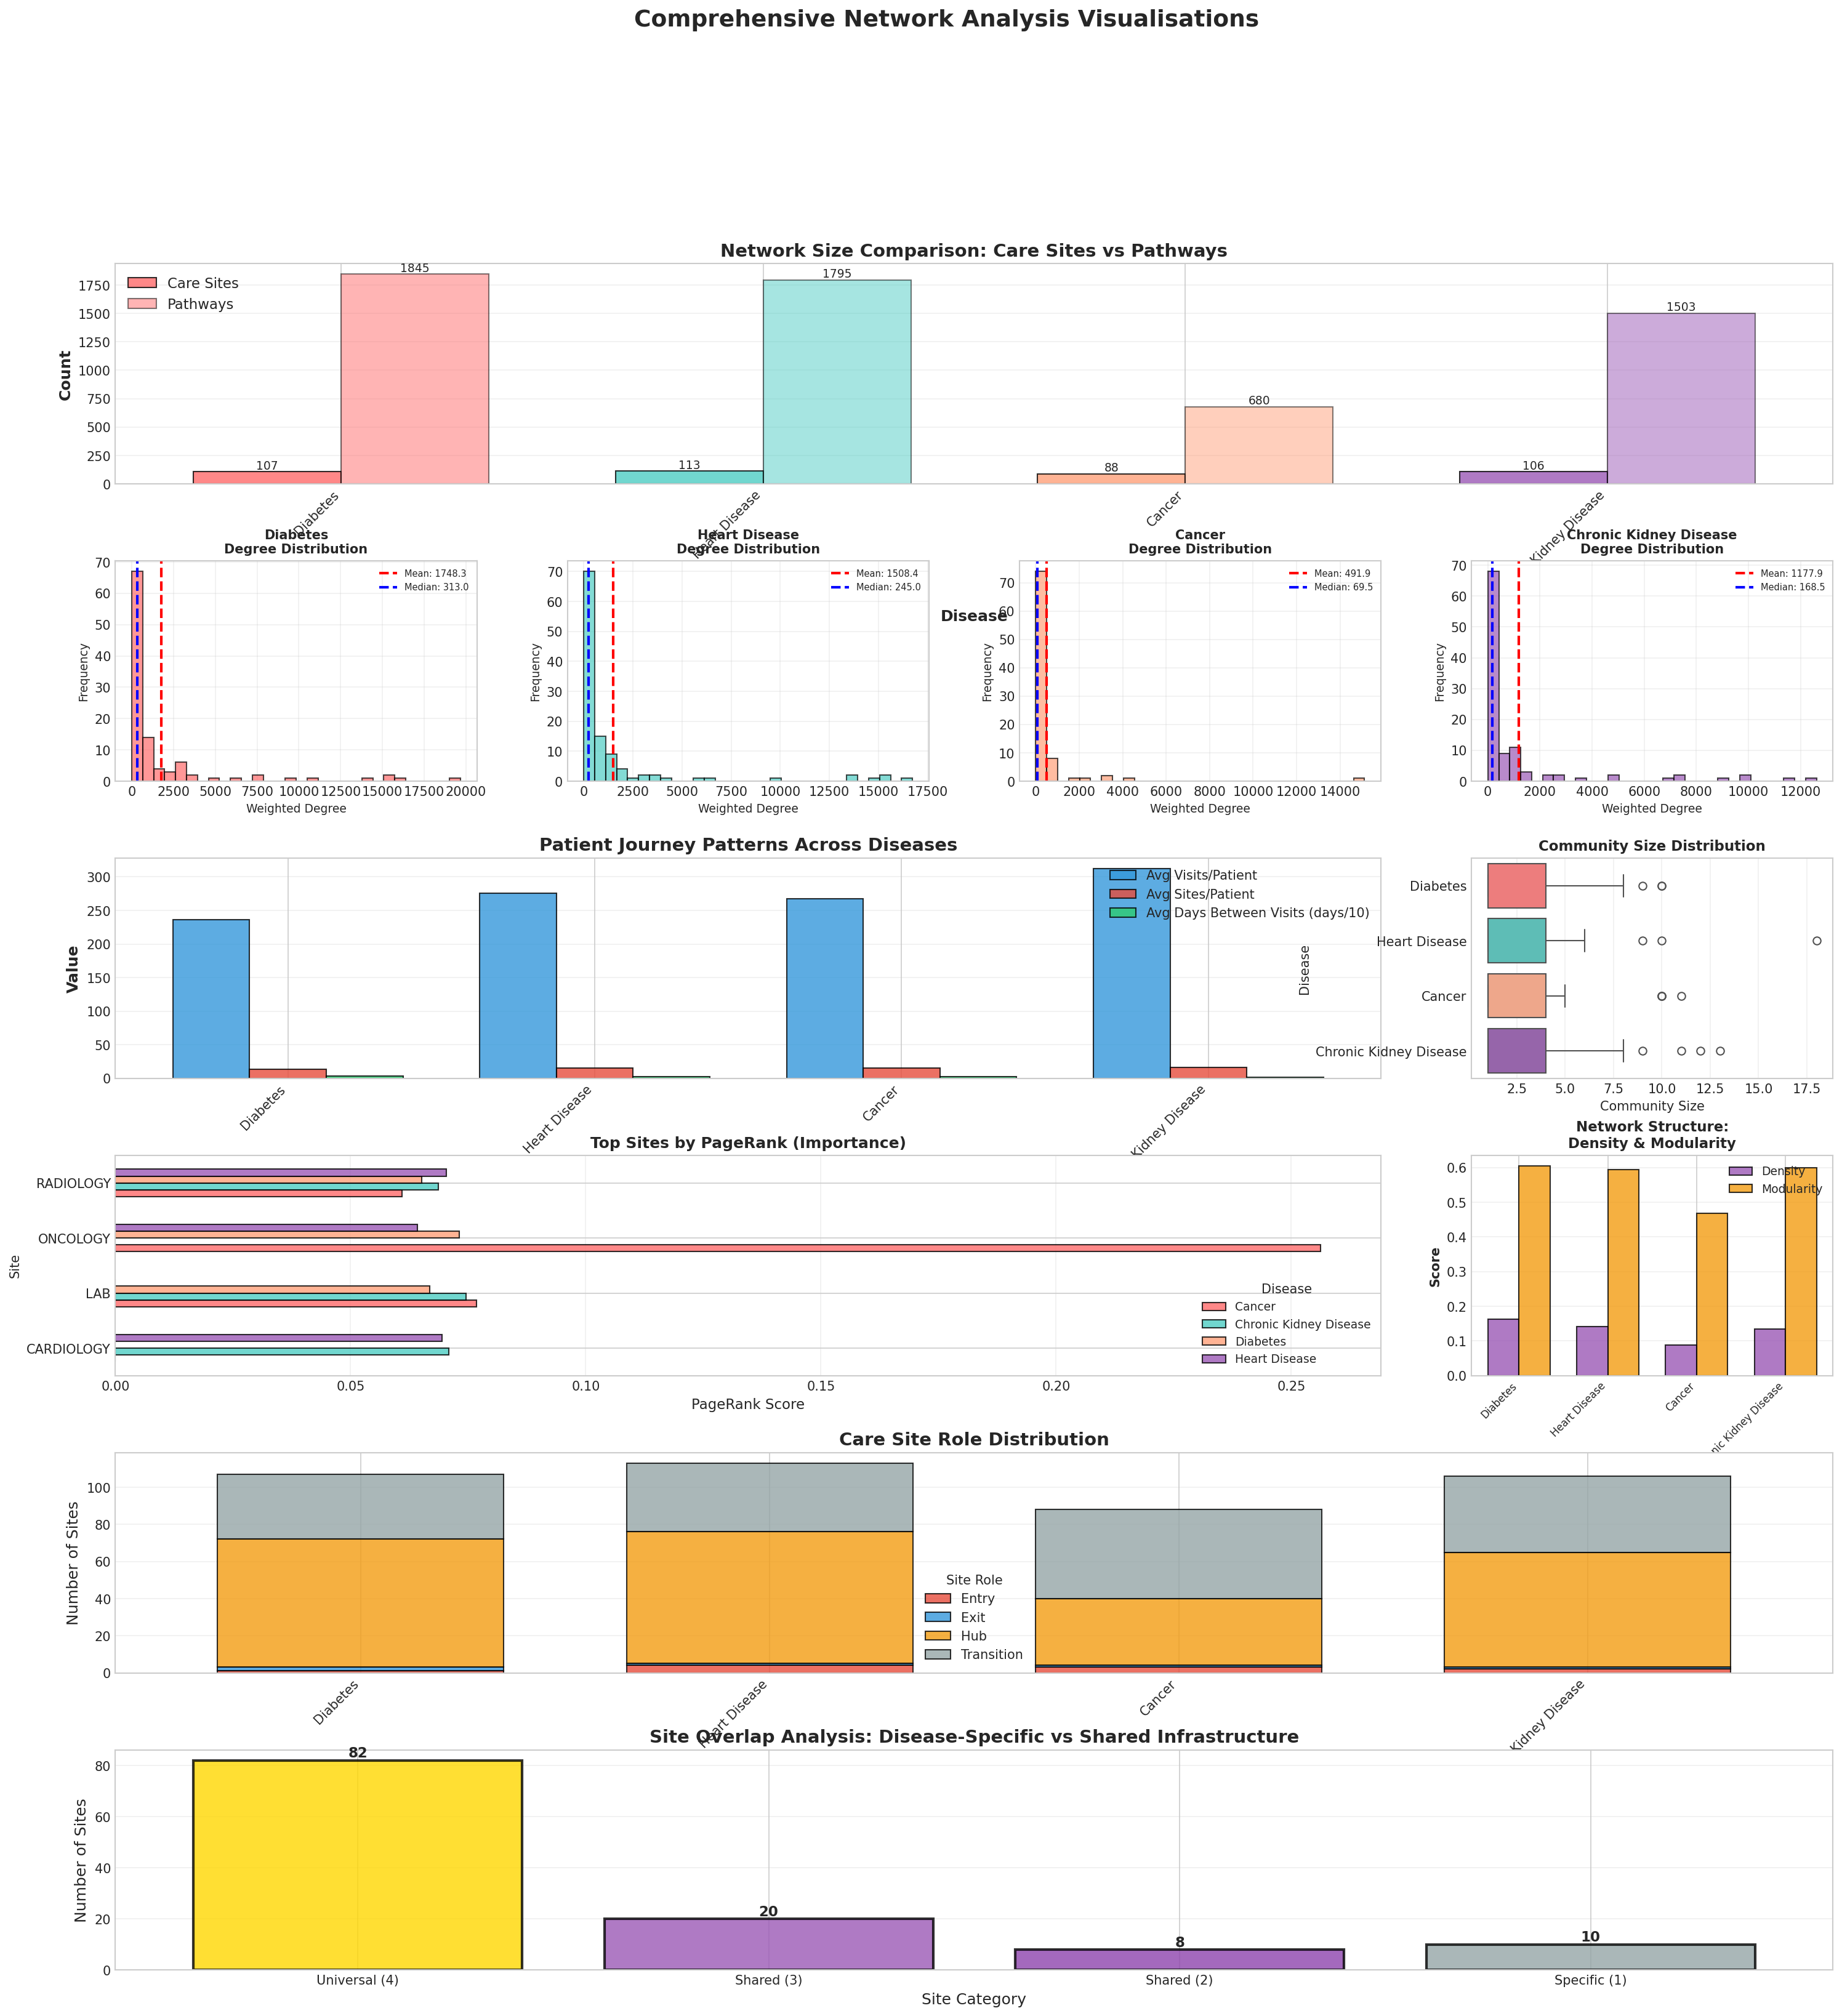

In [21]:
# Comprehensive Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_palette("husl")
fig = plt.figure(figsize=(24, 24))  # Wider to accommodate 4 columns
gs = fig.add_gridspec(6, 4, hspace=0.35, wspace=0.25)

# This tracks which diseases use each care site
node_diseases = {}

for disease_name, G in disease_networks.items():
    for node in G.nodes():
        if node not in node_diseases:
            node_diseases[node] = set()
        node_diseases[node].add(disease_name)

print(f"\n✓ Created node_diseases mapping for {len(node_diseases)} care sites")

# Quick stats
universal = sum(1 for diseases in node_diseases.values() if len(diseases) == 4)
shared = sum(1 for diseases in node_diseases.values() if 2 <= len(diseases) <= 3)
specific = sum(1 for diseases in node_diseases.values() if len(diseases) == 1)

print(f"   Universal (4 diseases): {universal}")
print(f"   Shared (2-3 diseases): {shared}")
print(f"   Disease-specific (1): {specific}")



# 1. NETWORK SIZE COMPARISON
ax1 = fig.add_subplot(gs[0, :])  # Spans all 4 columns
diseases = list(disease_networks.keys())
nodes_count = [disease_networks[d].number_of_nodes() for d in diseases]
edges_count = [disease_networks[d].number_of_edges() for d in diseases]

x = np.arange(len(diseases))
width = 0.35

bars1 = ax1.bar(x - width/2, nodes_count, width, label='Care Sites',
                color=[disease_colors[d] for d in diseases], alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, edges_count, width, label='Pathways',
                color=[disease_colors[d] for d in diseases], alpha=0.5, edgecolor='black')

ax1.set_xlabel('Disease', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Network Size Comparison: Care Sites vs Pathways', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(diseases, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. DEGREE DISTRIBUTION COMPARISON
for idx, disease in enumerate(diseases):
    ax = fig.add_subplot(gs[1, idx])  # Now idx can be 0, 1, 2, 3 (all valid)
    G = disease_networks[disease]
    degrees = [deg for _, deg in G.degree(weight='weight')]

    ax.hist(degrees, bins=30, color=disease_colors[disease], alpha=0.7, edgecolor='black')
    ax.set_xlabel('Weighted Degree', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.set_title(f'{disease}\nDegree Distribution', fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

    # Add stats
    mean_deg = np.mean(degrees)
    median_deg = np.median(degrees)
    ax.axvline(mean_deg, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_deg:.1f}')
    ax.axvline(median_deg, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_deg:.1f}')
    ax.legend(fontsize=7)

# 3. PATIENT JOURNEY METRICS COMPARISON
ax3 = fig.add_subplot(gs[2, :3])  # Spans first 3 columns
journey_metrics = journey_df[['Disease', 'Avg Visits/Patient', 'Avg Sites/Patient', 'Avg Days Between Visits']]

x = np.arange(len(journey_metrics))
width = 0.25

ax3.bar(x - width, journey_metrics['Avg Visits/Patient'], width,
        label='Avg Visits/Patient', color='#3498db', alpha=0.8, edgecolor='black')
ax3.bar(x, journey_metrics['Avg Sites/Patient'], width,
        label='Avg Sites/Patient', color='#e74c3c', alpha=0.8, edgecolor='black')
ax3.bar(x + width, journey_metrics['Avg Days Between Visits']/10, width,
        label='Avg Days Between Visits (days/10)', color='#2ecc71', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Disease', fontsize=12, fontweight='bold')
ax3.set_ylabel('Value', fontsize=12, fontweight='bold')
ax3.set_title('Patient Journey Patterns Across Diseases', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(journey_metrics['Disease'], rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. COMMUNITY SIZE DISTRIBUTION
ax4 = fig.add_subplot(gs[2, 3])  # 4th column
comm_sizes = []
comm_labels = []

for disease in diseases:
    communities = metrics_results[disease]['communities']
    sizes = [len(c) for c in communities]
    comm_sizes.extend(sizes)
    comm_labels.extend([disease] * len(sizes))

comm_df_plot = pd.DataFrame({'Disease': comm_labels, 'Community Size': comm_sizes})
sns.boxplot(data=comm_df_plot, y='Disease', x='Community Size', ax=ax4, palette=disease_colors)
ax4.set_title('Community Size Distribution', fontsize=11, fontweight='bold')
ax4.set_xlabel('Community Size', fontsize=10)
ax4.set_ylabel('Disease', fontsize=10)
ax4.grid(axis='x', alpha=0.3)

# 5. CENTRALITY MEASURES COMPARISON
centrality_comparison = []
for disease, G in disease_networks.items():
    metrics = metrics_results[disease]
    top_pr = dict(metrics['top_pagerank'][:5])
    top_bt = dict(metrics['top_betweenness'][:5])

    for site in set(list(top_pr.keys())[:3]):
        centrality_comparison.append({
            'Disease': disease,
            'Site': site[:25],
            'PageRank': top_pr.get(site, 0),
            'Betweenness': top_bt.get(site, 0) * 100
        })

cent_df = pd.DataFrame(centrality_comparison)

ax5a = fig.add_subplot(gs[3, :3])  # First 3 columns
pivot_pr = cent_df.pivot(index='Site', columns='Disease', values='PageRank')
pivot_pr.plot(kind='barh', ax=ax5a, color=[disease_colors[d] for d in diseases], alpha=0.8, edgecolor='black')
ax5a.set_title('Top Sites by PageRank (Importance)', fontsize=12, fontweight='bold')
ax5a.set_xlabel('PageRank Score', fontsize=11)
ax5a.legend(title='Disease', fontsize=9)
ax5a.grid(axis='x', alpha=0.3)

# 6. NETWORK DENSITY & MODULARITY
ax6 = fig.add_subplot(gs[3, 3])  # 4th column
density_data = [metrics_results[d]['density'] for d in diseases]
modularity_data = [metrics_results[d]['modularity'] for d in diseases]

x = np.arange(len(diseases))
width = 0.35

ax6.bar(x - width/2, density_data, width, label='Density',
        color='#9b59b6', alpha=0.8, edgecolor='black')
ax6.bar(x + width/2, modularity_data, width, label='Modularity',
        color='#f39c12', alpha=0.8, edgecolor='black')

ax6.set_xlabel('Disease', fontsize=10, fontweight='bold')
ax6.set_ylabel('Score', fontsize=10, fontweight='bold')
ax6.set_title('Network Structure:\nDensity & Modularity', fontsize=11, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(diseases, rotation=45, ha='right', fontsize=8)
ax6.legend(fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# 7. SITE ROLE DISTRIBUTION
role_counts = {disease: {'Entry': 0, 'Exit': 0, 'Hub': 0, 'Transition': 0} for disease in diseases}

for disease, G in disease_networks.items():
    for node in G.nodes():
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)

        if in_deg == 0 and out_deg > 0:
            role_counts[disease]['Entry'] += 1
        elif out_deg == 0 and in_deg > 0:
            role_counts[disease]['Exit'] += 1
        elif in_deg > 5 and out_deg > 5:
            role_counts[disease]['Hub'] += 1
        else:
            role_counts[disease]['Transition'] += 1

role_df = pd.DataFrame(role_counts).T

ax7 = fig.add_subplot(gs[4, :])  # Spans all 4 columns
role_df.plot(kind='bar', stacked=True, ax=ax7, color=['#e74c3c', '#3498db', '#f39c12', '#95a5a6'],
             alpha=0.8, edgecolor='black', width=0.7)
ax7.set_title('Care Site Role Distribution', fontsize=14, fontweight='bold')
ax7.set_xlabel('Disease', fontsize=12)
ax7.set_ylabel('Number of Sites', fontsize=12)
ax7.legend(title='Site Role', fontsize=10)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45, ha='right')
ax7.grid(axis='y', alpha=0.3)

# 8. SHARED vs DISEASE-SPECIFIC SITES
ax8 = fig.add_subplot(gs[5, :])  # Spans all 4 columns

node_overlap_counts = {'Universal (4)': 0, 'Shared (3)': 0, 'Shared (2)': 0, 'Specific (1)': 0}

for node in combined_G.nodes():
    disease_count = len(node_diseases[node])
    if disease_count == 4:
        node_overlap_counts['Universal (4)'] += 1
    elif disease_count == 3:
        node_overlap_counts['Shared (3)'] += 1
    elif disease_count == 2:
        node_overlap_counts['Shared (2)'] += 1
    else:
        node_overlap_counts['Specific (1)'] += 1

colors_overlap = ['#FFD700', '#9B59B6', '#8E44AD', '#95a5a6']
bars = ax8.bar(node_overlap_counts.keys(), node_overlap_counts.values(),
               color=colors_overlap, alpha=0.8, edgecolor='black', linewidth=2)

ax8.set_title('Site Overlap Analysis: Disease-Specific vs Shared Infrastructure',
              fontsize=14, fontweight='bold')
ax8.set_xlabel('Site Category', fontsize=12)
ax8.set_ylabel('Number of Sites', fontsize=12)
ax8.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Save figure
plt.suptitle('Comprehensive Network Analysis Visualisations', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: comprehensive_analysis.png")
plt.show()
